# Computer Vision Assignment 3: Object Detection and Counting from Drone-based Images

The focus of this assignment was to use YOLO (You Only Look Once) pre-trained model to do object detection. The task was detecting the car objects and counting them for each image. The assignment involved fine-tuning YOLO under different configurations, evaluating these models' detection and counting performance by comparing the prediction results with ground-truth annotations using metrics such as Precision, Recall, Exact Match Accuracy and Mean Squared Error.

## Import Statements

In [1]:
%matplotlib inline

In [22]:
import os
import shutil
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import glob
import cv2
import random

## Helper Functions

In [ ]:
def show_image(title, image_path):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{title}")
    plt.show()

## Data Preparation

A drone-based car parking dataset was used in this assignment. Since the dataset was not structured in the YOLO format, we needed to prepare the dataset for YOLO usage. The dataset was split into training, validation, and test sets. The annotations were not in the YOLO format, thus they were converted to YOLO bounding box format (class_name, x_center, y_center, width, height). Each image had its associated label in their respective sets. The folder and naming structure followed the YOLO's convention. The data.yaml file that were used by YOLO was configured to define the dataset paths and class information.  

In [4]:
# Paths
DATASET_PATH = 'cars_dataset'
IMAGE_PATH = os.path.join(DATASET_PATH, 'Images')
ANNOTATION_PATH = os.path.join(DATASET_PATH, 'Annotations')
IMAGESETS_PATH = os.path.join(DATASET_PATH, 'ImageSets')
YOLOV8_DATASET_PATH = 'yolo_cars_dataset'

# YOLO format directories
# Delete existing YOLOv8 dataset directory if it exists
if os.path.exists(YOLOV8_DATASET_PATH):
    shutil.rmtree(YOLOV8_DATASET_PATH)
# Create YOLOv8 dataset directory structure
os.makedirs(YOLOV8_DATASET_PATH, exist_ok=True)
for split in ['train', 'val', 'test']:
    split_path = os.path.join(YOLOV8_DATASET_PATH, split)
    os.makedirs(os.path.join(split_path, 'images'), exist_ok=True)
    os.makedirs(os.path.join(split_path, 'labels'), exist_ok=True)

In [ ]:

def convert_annotation(file_path, img_width, img_height):
    """ Converts the annotation to YOLO format """
    yolo_annotations = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if not line.strip():
                continue
            try:
                x_min, y_min, x_max, y_max, class_id = map(int, line.split())
                x_center = ((x_min + x_max) / 2) / img_width
                y_center = ((y_min + y_max) / 2) / img_height
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height
                yolo_annotations.append(f"0 {x_center} {y_center} {width} {height}")
            except Exception as e:
                print(f"Error processing line: {line.strip()}. Error: {e}")
    return yolo_annotations

def prepare_dataset(split):
    """ Prepares the dataset for a given split (train, val, test) """
    with open(os.path.join(IMAGESETS_PATH, f'{split}.txt'), 'r') as file:
        image_ids = [line.strip() for line in file.readlines()]

    for image_id in image_ids:
        image_file = f"{image_id}.png"
        annotation_file = f"{image_id}.txt"

        src_img_path = os.path.join(IMAGE_PATH, image_file)
        src_ann_path = os.path.join(ANNOTATION_PATH, annotation_file)

        if os.path.exists(src_img_path) and os.path.exists(src_ann_path):
            
            with Image.open(src_img_path) as img:
                width, height = img.size

            
            yolo_annotations = convert_annotation(src_ann_path, width, height)
            dest_label_path = os.path.join(YOLOV8_DATASET_PATH, split, 'labels', annotation_file)
            with open(dest_label_path, 'w') as file:
                file.write("\n".join(yolo_annotations))
            
            
            dest_image_path = os.path.join(YOLOV8_DATASET_PATH, split, 'images', image_file)
            shutil.copyfile(src_img_path, dest_image_path)

In [6]:
# Prepare all splits
for split in ['train', 'val', 'test']:
    prepare_dataset(split)

print("Dataset preparation is complete!")

Dataset preparation is complete!


In [7]:
train_dir_path = os.path.abspath(os.path.join(YOLOV8_DATASET_PATH, 'train', 'images'))
val_dir_path = os.path.abspath(os.path.join(YOLOV8_DATASET_PATH, 'val', 'images'))
test_dir_path = os.path.abspath(os.path.join(YOLOV8_DATASET_PATH, 'test', 'images'))

data_yaml = f"""
train: {train_dir_path}
val: {val_dir_path}
test: {test_dir_path}

nc: 1
names: ['car']
"""

with open("yolo_cars_dataset/data.yaml", "w") as f:
    f.write(data_yaml)

print("YOLOv8 data.yaml file created successfully!")

YOLOv8 data.yaml file created successfully!


## Train and Evaluate YOLO with Different Frozen Layers

### Helper Functions for Training and Evaluation

In [11]:
def train_model(epochs, optimizer, lr, batch, name, freeze):

    # Load pre-trained model
    model = YOLO('yolov8n.pt')

    # Train model
    model.train(
        data='yolo_cars_dataset/data.yaml',  
        epochs=epochs,
        batch=batch,
        imgsz=640,
        optimizer=optimizer,
        lr0=lr,
        project='yolo_models',
        name=name,
        device=0,
        freeze=freeze
    )

    print(f"Training completed for model: {name}")

    return model

def train_model_with_yolo_hyperparameters(epochs, optimizer, lr, batch, name, freeze, conf, iou):

    # Load pre-trained model
    model = YOLO('yolov8n.pt')

    # Train model
    model.train(
        data='yolo_cars_dataset/data.yaml',  
        epochs=epochs,
        batch=batch,
        imgsz=640,
        optimizer=optimizer,
        lr0=lr,
        project='yolo_models',
        name=name,
        device=0,
        freeze=freeze,
        conf=conf,
        iou=iou,
    )

    print(f"Training completed for model: {name}")

    return model

def show_loss_plots(model_name):

    results_path = os.path.join('yolo_models', model_name, 'results.png')
    if os.path.exists(results_path):
        show_image(f"Training Results: {model_name}", results_path)
    else:
        print(f"results.png not found for model '{model_name}' at {results_path}")

def evaluate_model(name, split):

    model_path = os.path.join('yolo_models', name, 'weights', 'best.pt')
    model = YOLO(model_path)

    metrics = model.val(
        data='yolo_cars_dataset/data.yaml',
        project=f'yolo_{split}_metrics',
        name=name,
        split=split,
    )
    return metrics

def evaluate_model_with_yolo_hyperparameters(name, split, conf=0.25, iou=0.7):

    model_path = os.path.join('yolo_models', name, 'weights', 'best.pt')
    model = YOLO(model_path)

    metrics = model.val(
        data='yolo_cars_dataset/data.yaml',
        project=f'yolo_{split}_metrics',
        name=name,
        split=split,
        conf=conf,
        iou=iou,
    )
    return metrics

def predict_model(name, split):

    model_path = os.path.join('yolo_models', name, 'weights', 'best.pt')
    model = YOLO(model_path)

    results = model.predict(
        source=f'yolo_cars_dataset/{split}/images',
        save=True,
        save_txt=True,
        project=f'yolo_{split}_predictions',
        name=name,
        verbose=False,
    )
    return results

def predict_model_with_yolo_hyperparameters(name, split, conf=0.25, iou=0.7):
    model_path = os.path.join('yolo_models', name, 'weights', 'best.pt')
    model = YOLO(model_path)

    results = model.predict(
        source=f'yolo_cars_dataset/{split}/images',
        save=True,
        save_txt=True,
        project=f'yolo_{split}_predictions',
        name=name,
        conf=conf,
        iou=iou,
        verbose=False,
    )
    return results

def count_labels_in_file(file_path):

    if not os.path.exists(file_path):
        return 0
    with open(file_path, 'r') as f:
        return len(f.readlines())

def evaluate_detection_counts(name, split):

    pred_dir = os.path.join(f'yolo_{split}_predictions', name, 'labels')
    gt_dir = os.path.join('yolo_cars_dataset', split, 'labels')

    if not os.path.exists(pred_dir):
        raise FileNotFoundError(f"Prediction directory not found: {pred_dir}")

    pred_files = sorted(glob.glob(os.path.join(gt_dir, '*.txt')))  # use GT files as base

    total = 0
    exact_match = 0
    squared_errors = []

    for gt_file in pred_files:
        filename = os.path.basename(gt_file)
        gt_count = count_labels_in_file(gt_file)
        pred_file = os.path.join(pred_dir, filename)
        pred_count = count_labels_in_file(pred_file)

        if gt_count == pred_count:
            exact_match += 1

        squared_errors.append((pred_count - gt_count) ** 2)
        total += 1

    exact_match_accuracy = (exact_match / total) * 100
    mse = np.mean(squared_errors)

    return {
        'exact_match_accuracy': exact_match_accuracy,
        'mse': mse
    }



### Train Models with Different Freezes

A baseline configuration of learning hyperparameters are selected in this section to ensure fair comparison between models that have their different layers frozen. The selected learning hyperparameters follow an industry standart that are used when training CNN models, their values are: "Epochs : 50", "Learning Rate : 0.001", "Optimizer : Adam", "Batch Size : 16". Using this setup, we trained multiple YOLOv8 models with different numbers of frozen layers (0, 5, 10, and 21). The evaluation of these models are presented in the next section.

In [9]:
for freeze in [0, 5, 10, 21]:
    train_model(
        epochs=50,
        optimizer='Adam',
        lr=0.001,
        batch=16,
        name=f'freeze_{freeze}_blocks_br_16_lr_0.001_adam',
        freeze=freeze
    )

New https://pypi.org/project/ultralytics/8.3.142 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=freeze_0_blocks_br_16_lr_0.001_adam

train: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\train\labels... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:02<00:00, 406.15it/s]


train: New cache created: C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\train\labels.cache
val: Fast image access  (ping: 0.10.0 ms, read: 1303.5109.6 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 306.72it/s]

val: New cache created: C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache


Plotting labels to yolo_models\freeze_0_blocks_br_16_lr_0.001_adam\labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_models\freeze_0_blocks_br_16_lr_0.001_adam
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.04G      1.322      1.423     0.9763       1118        640: 100%|██████████| 63/63 [00:29<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        200      11906      0.941      0.862      0.947       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.74G      1.077     0.7048     0.9058        787        640: 100%|██████████| 63/63 [00:14<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]

                   all        200      11906      0.967      0.933      0.976      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.69G      1.023     0.6317     0.8884        870        640: 100%|██████████| 63/63 [00:12<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        200      11906      0.984      0.949      0.986      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.12G     0.9798     0.5928     0.8812        669        640: 100%|██████████| 63/63 [00:12<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        200      11906      0.988      0.956      0.989      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.48G     0.9432     0.5584      0.868        908        640: 100%|██████████| 63/63 [00:12<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        200      11906       0.99      0.965       0.99      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.97G     0.9213     0.5368      0.867        585        640: 100%|██████████| 63/63 [00:41<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200      11906      0.991      0.968      0.991      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.79G     0.9017     0.5117     0.8602        922        640: 100%|██████████| 63/63 [00:12<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        200      11906      0.988      0.973      0.992      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.39G     0.8948     0.5061      0.859        766        640: 100%|██████████| 63/63 [00:12<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

                   all        200      11906      0.988      0.972      0.992      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.92G     0.8795     0.4912     0.8565        900        640: 100%|██████████| 63/63 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        200      11906      0.991      0.975      0.993      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.05G     0.8656     0.4806     0.8538       1024        640: 100%|██████████| 63/63 [00:18<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200      11906      0.989      0.976      0.993      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.79G     0.8529     0.4689     0.8513        902        640: 100%|██████████| 63/63 [00:13<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        200      11906      0.991      0.977      0.993      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.91G     0.8439     0.4619     0.8495        736        640: 100%|██████████| 63/63 [00:13<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        200      11906      0.991      0.978      0.994      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.55G     0.8571     0.4615     0.8514       1119        640: 100%|██████████| 63/63 [00:12<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        200      11906      0.991      0.977      0.994      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.67G     0.8363     0.4498     0.8451        931        640: 100%|██████████| 63/63 [00:36<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]

                   all        200      11906      0.991      0.978      0.994      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.36G     0.8368     0.4496     0.8469        983        640: 100%|██████████| 63/63 [00:14<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        200      11906      0.993      0.978      0.994      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.12G      0.843      0.448     0.8462       1080        640: 100%|██████████| 63/63 [00:12<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200      11906      0.992      0.979      0.994       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.81G     0.8274     0.4394     0.8436        827        640: 100%|██████████| 63/63 [00:16<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        200      11906      0.992      0.981      0.994      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.79G      0.828     0.4349     0.8442        843        640: 100%|██████████| 63/63 [00:13<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        200      11906      0.992      0.981      0.994      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.18G     0.8327     0.4346     0.8443        718        640: 100%|██████████| 63/63 [00:12<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200      11906      0.992      0.981      0.994      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       5.5G     0.8095     0.4281     0.8439        772        640: 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200      11906      0.992      0.982      0.994      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.69G     0.8025     0.4182     0.8401        949        640: 100%|██████████| 63/63 [00:12<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200      11906      0.993      0.983      0.994      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       4.1G     0.7996     0.4165     0.8394       1063        640: 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        200      11906      0.993      0.984      0.994      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.47G     0.8025     0.4162     0.8408       1217        640: 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        200      11906      0.992      0.984      0.994      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.27G     0.7936     0.4119      0.839        502        640: 100%|██████████| 63/63 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        200      11906      0.994      0.982      0.994      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.38G      0.786     0.4064     0.8357        857        640: 100%|██████████| 63/63 [00:22<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200      11906      0.993      0.983      0.994      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       5.9G     0.8038     0.4119     0.8396        986        640: 100%|██████████| 63/63 [00:13<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200      11906      0.993      0.983      0.994      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.92G     0.7814     0.4018      0.839        908        640: 100%|██████████| 63/63 [00:13<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200      11906      0.993      0.983      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.35G      0.784     0.4028     0.8367        914        640: 100%|██████████| 63/63 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200      11906      0.993      0.984      0.994      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.53G     0.7815     0.3972     0.8368        730        640: 100%|██████████| 63/63 [00:12<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        200      11906      0.993      0.985      0.994      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.07G     0.7783     0.3956     0.8353        709        640: 100%|██████████| 63/63 [00:12<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        200      11906      0.994      0.983      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.94G       0.78     0.3976     0.8339       1028        640: 100%|██████████| 63/63 [00:58<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]

                   all        200      11906      0.993      0.985      0.994      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.28G     0.7676     0.3893     0.8355        797        640: 100%|██████████| 63/63 [00:12<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        200      11906      0.992      0.985      0.994      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.87G      0.769     0.3896     0.8343        935        640: 100%|██████████| 63/63 [00:12<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200      11906      0.993      0.984      0.994      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.27G     0.7605     0.3859     0.8327       1109        640: 100%|██████████| 63/63 [00:12<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        200      11906      0.994      0.985      0.994      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.48G     0.7701      0.387     0.8337        949        640: 100%|██████████| 63/63 [00:22<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        200      11906      0.992      0.985      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.27G     0.7623     0.3827     0.8302        800        640: 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200      11906      0.992      0.986      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.36G     0.7546      0.381     0.8326        895        640: 100%|██████████| 63/63 [00:23<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        200      11906      0.993      0.984      0.994      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.47G     0.7506     0.3789     0.8312        863        640: 100%|██████████| 63/63 [00:15<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        200      11906      0.992      0.987      0.994      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.75G     0.7575     0.3779     0.8299       1134        640: 100%|██████████| 63/63 [00:12<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        200      11906      0.993      0.986      0.994      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       5.9G     0.7534     0.3782     0.8309        719        640: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200      11906      0.993      0.986      0.994      0.831


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.71G     0.7319     0.3786     0.8312        667        640: 100%|██████████| 63/63 [00:12<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]

                   all        200      11906      0.994      0.983      0.994      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.96G     0.7194     0.3669     0.8282        629        640: 100%|██████████| 63/63 [00:12<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200      11906      0.993      0.984      0.994       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.34G     0.7196     0.3612     0.8281        500        640: 100%|██████████| 63/63 [00:12<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        200      11906      0.993      0.985      0.994      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       4.1G     0.7134     0.3564     0.8271        441        640: 100%|██████████| 63/63 [00:11<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200      11906      0.993      0.984      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.33G     0.7118     0.3537     0.8283        447        640: 100%|██████████| 63/63 [00:11<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200      11906      0.994      0.984      0.994      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.33G      0.701     0.3495     0.8256        444        640: 100%|██████████| 63/63 [00:12<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        200      11906      0.993      0.986      0.994      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.92G     0.6938     0.3451      0.826        431        640: 100%|██████████| 63/63 [00:12<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        200      11906      0.993      0.986      0.994      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.47G     0.6934     0.3444     0.8247        712        640: 100%|██████████| 63/63 [00:11<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        200      11906      0.994      0.985      0.994      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.11G     0.6913     0.3434     0.8247        601        640: 100%|██████████| 63/63 [00:12<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        200      11906      0.993      0.986      0.994      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.18G     0.6892     0.3403     0.8224        611        640: 100%|██████████| 63/63 [00:11<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200      11906      0.993      0.986      0.994      0.838



50 epochs completed in 0.271 hours.
Optimizer stripped from yolo_models\freeze_0_blocks_br_16_lr_0.001_adam\weights\last.pt, 6.2MB
Optimizer stripped from yolo_models\freeze_0_blocks_br_16_lr_0.001_adam\weights\best.pt, 6.2MB

Validating yolo_models\freeze_0_blocks_br_16_lr_0.001_adam\weights\best.pt...
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


                   all        200      11906      0.993      0.986      0.994      0.838
Speed: 0.5ms preprocess, 2.8ms inference, 0.0ms loss, 8.0ms postprocess per image
Results saved to yolo_models\freeze_0_blocks_br_16_lr_0.001_adam
Training completed for model: freeze_0_blocks_br_16_lr_0.001_adam
New https://pypi.org/project/ultralytics/8.3.142 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, fre

train: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\train\labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 1044.8147.5 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to yolo_models\freeze_5_blocks_br_16_lr_0.001_adam\labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_models\freeze_5_blocks_br_16_lr_0.001_adam
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.35G      1.387      1.463     0.9953       1118        640: 100%|██████████| 63/63 [00:17<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        200      11906      0.943      0.903      0.961      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.01G      1.178     0.7611     0.9261        787        640: 100%|██████████| 63/63 [00:12<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.95it/s]

                   all        200      11906      0.961      0.934      0.975      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.95G      1.125       0.69     0.9091        870        640: 100%|██████████| 63/63 [00:11<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]

                   all        200      11906      0.967       0.94      0.979      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.38G       1.07     0.6412        0.9        669        640: 100%|██████████| 63/63 [00:11<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        200      11906      0.981      0.954      0.985       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.75G      1.038      0.608     0.8858        908        640: 100%|██████████| 63/63 [00:11<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        200      11906      0.987      0.964      0.988      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.23G      1.015     0.5849     0.8862        585        640: 100%|██████████| 63/63 [00:33<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        200      11906      0.989      0.959      0.988      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.05G     0.9998     0.5631     0.8795        922        640: 100%|██████████| 63/63 [00:11<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        200      11906      0.989      0.967       0.99      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.65G     0.9822     0.5529     0.8752        766        640: 100%|██████████| 63/63 [00:11<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        200      11906      0.988      0.971      0.991      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.19G     0.9581     0.5315     0.8714        900        640: 100%|██████████| 63/63 [00:11<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

                   all        200      11906       0.99      0.975      0.993      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.32G     0.9431     0.5204     0.8677       1024        640: 100%|██████████| 63/63 [00:14<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]

                   all        200      11906       0.99      0.972      0.992      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.05G      0.932     0.5066     0.8656        902        640: 100%|██████████| 63/63 [00:11<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        200      11906      0.987      0.974      0.992      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.17G     0.9272     0.5026      0.865        736        640: 100%|██████████| 63/63 [00:11<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        200      11906      0.989      0.975      0.993      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.82G     0.9377      0.502     0.8646       1119        640: 100%|██████████| 63/63 [00:11<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200      11906       0.99      0.975      0.993      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.94G     0.9256     0.4905       0.86        931        640: 100%|██████████| 63/63 [00:30<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        200      11906       0.99      0.975      0.993      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.78G     0.9113     0.4844     0.8597        983        640: 100%|██████████| 63/63 [00:11<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        200      11906      0.992      0.975      0.993      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.38G     0.9014      0.479     0.8563       1080        640: 100%|██████████| 63/63 [00:11<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        200      11906      0.991      0.977      0.993      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.08G     0.8889     0.4751     0.8548        827        640: 100%|██████████| 63/63 [00:13<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

                   all        200      11906       0.99      0.979      0.993       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.05G     0.8899     0.4711     0.8547        843        640: 100%|██████████| 63/63 [00:11<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200      11906      0.992      0.978      0.994      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.45G     0.8874     0.4663     0.8547        718        640: 100%|██████████| 63/63 [00:11<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200      11906      0.991       0.98      0.994      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.76G     0.8749     0.4601     0.8547        772        640: 100%|██████████| 63/63 [00:11<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        200      11906      0.991       0.98      0.994      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.96G     0.8667      0.453     0.8514        949        640: 100%|██████████| 63/63 [00:11<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

                   all        200      11906      0.992       0.98      0.994      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.37G     0.8587     0.4491     0.8493       1063        640: 100%|██████████| 63/63 [00:11<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200      11906      0.991       0.98      0.994      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.73G     0.8615     0.4482     0.8507       1217        640: 100%|██████████| 63/63 [00:11<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200      11906      0.991      0.979      0.993      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.53G     0.8581     0.4448     0.8497        502        640: 100%|██████████| 63/63 [00:11<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        200      11906      0.993      0.978      0.994        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.64G     0.8509     0.4405      0.847        857        640: 100%|██████████| 63/63 [00:16<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        200      11906       0.99      0.981      0.994      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.17G     0.8643     0.4445     0.8499        986        640: 100%|██████████| 63/63 [00:11<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        200      11906      0.991      0.981      0.994      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.19G     0.8399     0.4345     0.8488        908        640: 100%|██████████| 63/63 [00:11<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        200      11906      0.992      0.981      0.994      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.61G      0.841     0.4322     0.8459        914        640: 100%|██████████| 63/63 [00:11<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        200      11906      0.992      0.983      0.994       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       4.8G     0.8369     0.4273     0.8463        730        640: 100%|██████████| 63/63 [00:11<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        200      11906      0.992      0.981      0.994      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.33G     0.8373     0.4258     0.8446        709        640: 100%|██████████| 63/63 [00:10<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        200      11906      0.992      0.982      0.994      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       6.2G      0.837     0.4275     0.8431       1028        640: 100%|██████████| 63/63 [00:13<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        200      11906      0.993      0.981      0.994      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.54G     0.8241     0.4183     0.8447        797        640: 100%|██████████| 63/63 [00:10<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200      11906      0.992      0.981      0.994      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.13G     0.8254     0.4193     0.8434        935        640: 100%|██████████| 63/63 [00:10<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200      11906      0.992      0.981      0.994      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.54G     0.8213     0.4179     0.8422       1109        640: 100%|██████████| 63/63 [00:10<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200      11906      0.993      0.981      0.994      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.74G     0.8319     0.4178     0.8432        949        640: 100%|██████████| 63/63 [00:42<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        200      11906      0.993       0.98      0.994       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.53G     0.8248     0.4141     0.8394        800        640: 100%|██████████| 63/63 [00:11<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200      11906      0.994      0.981      0.994      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.62G     0.8098     0.4106     0.8413        895        640: 100%|██████████| 63/63 [00:19<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        200      11906      0.993      0.982      0.994      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.73G     0.8083     0.4088     0.8401        863        640: 100%|██████████| 63/63 [00:11<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200      11906      0.994      0.982      0.994      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.02G     0.8127     0.4078     0.8384       1134        640: 100%|██████████| 63/63 [00:11<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        200      11906      0.993      0.982      0.994      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.17G     0.8091     0.4084     0.8398        719        640: 100%|██████████| 63/63 [00:11<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        200      11906      0.993      0.981      0.994      0.818


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.97G     0.7662      0.396     0.8362        667        640: 100%|██████████| 63/63 [00:10<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        200      11906      0.991      0.982      0.994      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.22G     0.7559     0.3861     0.8336        629        640: 100%|██████████| 63/63 [00:10<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200      11906      0.993      0.982      0.994      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       3.6G     0.7562      0.384     0.8336        500        640: 100%|██████████| 63/63 [00:09<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        200      11906      0.993      0.982      0.994      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.36G     0.7504     0.3806     0.8327        441        640: 100%|██████████| 63/63 [00:09<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        200      11906      0.993      0.983      0.994      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.59G      0.745     0.3761     0.8335        447        640: 100%|██████████| 63/63 [00:10<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        200      11906      0.992      0.983      0.994      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       4.6G     0.7397     0.3732     0.8312        444        640: 100%|██████████| 63/63 [00:10<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        200      11906      0.993      0.983      0.994      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.19G      0.733     0.3689      0.832        431        640: 100%|██████████| 63/63 [00:10<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        200      11906      0.993      0.984      0.994      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.73G     0.7322     0.3688     0.8307        712        640: 100%|██████████| 63/63 [00:09<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        200      11906      0.994      0.983      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.37G     0.7301     0.3679     0.8306        601        640: 100%|██████████| 63/63 [00:10<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        200      11906      0.994      0.983      0.994       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.77G     0.7277     0.3653     0.8284        611        640: 100%|██████████| 63/63 [00:09<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200      11906      0.994      0.983      0.994      0.823



50 epochs completed in 0.227 hours.
Optimizer stripped from yolo_models\freeze_5_blocks_br_16_lr_0.001_adam\weights\last.pt, 6.2MB
Optimizer stripped from yolo_models\freeze_5_blocks_br_16_lr_0.001_adam\weights\best.pt, 6.2MB

Validating yolo_models\freeze_5_blocks_br_16_lr_0.001_adam\weights\best.pt...
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]


                   all        200      11906      0.993      0.984      0.994      0.823
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 9.9ms postprocess per image
Results saved to yolo_models\freeze_5_blocks_br_16_lr_0.001_adam
Training completed for model: freeze_5_blocks_br_16_lr_0.001_adam
New https://pypi.org/project/ultralytics/8.3.142 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, fre

train: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\train\labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 1013.5161.3 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to yolo_models\freeze_10_blocks_br_16_lr_0.001_adam\labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_models\freeze_10_blocks_br_16_lr_0.001_adam
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.13G      1.419      1.502      1.009       1118        640: 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

                   all        200      11906      0.951      0.887      0.957      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.82G      1.194     0.7827     0.9325        787        640: 100%|██████████| 63/63 [00:10<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

                   all        200      11906      0.969      0.931      0.975      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.77G      1.136     0.7034     0.9126        870        640: 100%|██████████| 63/63 [00:10<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        200      11906      0.976      0.943      0.979      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       4.2G      1.085     0.6539     0.9031        669        640: 100%|██████████| 63/63 [00:10<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        200      11906       0.98      0.956      0.984      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.56G      1.068     0.6266     0.8921        908        640: 100%|██████████| 63/63 [00:10<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

                   all        200      11906      0.982      0.957      0.985      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.05G      1.033     0.6015      0.889        585        640: 100%|██████████| 63/63 [00:27<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        200      11906      0.987      0.962      0.988      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.87G      1.017     0.5767     0.8827        922        640: 100%|██████████| 63/63 [00:10<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]

                   all        200      11906      0.987      0.963      0.989      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.47G      1.006     0.5692     0.8799        766        640: 100%|██████████| 63/63 [00:10<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        200      11906      0.986      0.965       0.99      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         5G     0.9997     0.5554     0.8794        900        640: 100%|██████████| 63/63 [00:10<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        200      11906      0.988      0.969      0.991      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.14G     0.9866     0.5452     0.8758       1024        640: 100%|██████████| 63/63 [00:12<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        200      11906      0.988      0.967      0.992      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.87G     0.9717     0.5338     0.8731        902        640: 100%|██████████| 63/63 [00:10<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        200      11906      0.989      0.967      0.992      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.99G     0.9576     0.5272     0.8699        736        640: 100%|██████████| 63/63 [00:10<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        200      11906      0.988       0.97      0.992      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.64G     0.9746      0.527     0.8715       1119        640: 100%|██████████| 63/63 [00:10<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200      11906      0.989      0.969      0.992      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.76G     0.9608     0.5169     0.8674        931        640: 100%|██████████| 63/63 [00:28<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        200      11906      0.989      0.969      0.992      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.44G     0.9497     0.5124     0.8665        983        640: 100%|██████████| 63/63 [00:10<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200      11906       0.99      0.971      0.993      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.19G     0.9431     0.5062     0.8632       1080        640: 100%|██████████| 63/63 [00:10<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        200      11906      0.988      0.973      0.993      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.89G     0.9335     0.5016     0.8623        827        640: 100%|██████████| 63/63 [00:12<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


                   all        200      11906      0.989      0.974      0.993      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.88G     0.9372     0.4978     0.8629        843        640: 100%|██████████| 63/63 [00:11<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        200      11906      0.988      0.973      0.993      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.26G      0.925     0.4906     0.8611        718        640: 100%|██████████| 63/63 [00:10<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200      11906      0.989      0.976      0.993      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.58G      0.917     0.4872     0.8621        772        640: 100%|██████████| 63/63 [00:10<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        200      11906       0.99      0.973      0.993      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.77G      0.912     0.4795     0.8585        949        640: 100%|██████████| 63/63 [00:10<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        200      11906      0.988      0.977      0.993      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.19G     0.9081     0.4765     0.8576       1063        640: 100%|██████████| 63/63 [00:10<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        200      11906      0.991      0.973      0.993       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.55G     0.9025     0.4725     0.8579       1217        640: 100%|██████████| 63/63 [00:10<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200      11906       0.99      0.974      0.993      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.35G     0.9042     0.4716     0.8572        502        640: 100%|██████████| 63/63 [00:10<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200      11906      0.989      0.977      0.993       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.46G      0.905     0.4689     0.8557        857        640: 100%|██████████| 63/63 [00:14<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        200      11906       0.99      0.976      0.993      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.99G     0.9134     0.4716     0.8579        986        640: 100%|██████████| 63/63 [00:10<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        200      11906       0.99      0.976      0.994      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         5G      0.887     0.4617     0.8568        908        640: 100%|██████████| 63/63 [00:10<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        200      11906      0.989      0.979      0.993      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.43G     0.8945     0.4625     0.8544        914        640: 100%|██████████| 63/63 [00:10<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        200      11906      0.989      0.978      0.994        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.61G     0.8897     0.4576     0.8545        730        640: 100%|██████████| 63/63 [00:10<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        200      11906      0.989      0.977      0.994      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.15G     0.8894     0.4569     0.8531        709        640: 100%|██████████| 63/63 [00:10<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        200      11906       0.99      0.977      0.994      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.02G      0.892     0.4601     0.8516       1028        640: 100%|██████████| 63/63 [00:11<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        200      11906      0.992      0.976      0.994      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.36G     0.8771     0.4496     0.8533        797        640: 100%|██████████| 63/63 [00:10<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200      11906      0.991      0.977      0.994      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.95G       0.88     0.4507     0.8521        935        640: 100%|██████████| 63/63 [00:10<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        200      11906      0.991      0.977      0.994      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.36G     0.8779     0.4503     0.8513       1109        640: 100%|██████████| 63/63 [00:10<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        200      11906      0.989      0.979      0.993      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.56G     0.8872     0.4494      0.852        949        640: 100%|██████████| 63/63 [00:14<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        200      11906       0.99      0.979      0.994      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.35G     0.8782     0.4464     0.8484        800        640: 100%|██████████| 63/63 [00:10<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        200      11906      0.991      0.976      0.993      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.43G     0.8666     0.4428     0.8507        895        640: 100%|██████████| 63/63 [00:18<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        200      11906       0.99       0.98      0.994      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.55G     0.8658     0.4418     0.8491        863        640: 100%|██████████| 63/63 [00:10<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        200      11906      0.991       0.98      0.994      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.83G     0.8733     0.4427     0.8481       1134        640: 100%|██████████| 63/63 [00:10<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200      11906      0.989      0.979      0.994      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.98G     0.8692     0.4431     0.8496        719        640: 100%|██████████| 63/63 [00:10<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        200      11906       0.99       0.98      0.994      0.806


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.79G     0.8144     0.4326     0.8443        667        640: 100%|██████████| 63/63 [00:10<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        200      11906       0.99       0.98      0.994      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.04G     0.8004     0.4181     0.8407        629        640: 100%|██████████| 63/63 [00:09<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200      11906      0.992      0.979      0.994      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.42G     0.7988      0.412     0.8403        500        640: 100%|██████████| 63/63 [00:09<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200      11906      0.991      0.981      0.994      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.18G     0.7967     0.4094     0.8402        441        640: 100%|██████████| 63/63 [00:08<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        200      11906      0.991       0.98      0.994      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.41G     0.7944     0.4066     0.8414        447        640: 100%|██████████| 63/63 [00:08<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        200      11906      0.992       0.98      0.994      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.42G     0.7895     0.4038     0.8387        444        640: 100%|██████████| 63/63 [00:08<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        200      11906      0.991      0.981      0.994      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.01G     0.7842     0.4006     0.8396        431        640: 100%|██████████| 63/63 [00:08<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        200      11906      0.991       0.98      0.994      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.55G     0.7809     0.3986     0.8381        712        640: 100%|██████████| 63/63 [00:09<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        200      11906      0.992      0.981      0.994      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.94G     0.7815     0.3983     0.8384        601        640: 100%|██████████| 63/63 [00:09<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]

                   all        200      11906      0.992      0.981      0.994       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.94G     0.7828     0.3973      0.837        611        640: 100%|██████████| 63/63 [00:09<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        200      11906      0.991      0.982      0.994      0.809



50 epochs completed in 0.201 hours.
Optimizer stripped from yolo_models\freeze_10_blocks_br_16_lr_0.001_adam\weights\last.pt, 6.2MB
Optimizer stripped from yolo_models\freeze_10_blocks_br_16_lr_0.001_adam\weights\best.pt, 6.2MB

Validating yolo_models\freeze_10_blocks_br_16_lr_0.001_adam\weights\best.pt...
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


                   all        200      11906      0.992      0.981      0.994      0.809
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 11.0ms postprocess per image
Results saved to yolo_models\freeze_10_blocks_br_16_lr_0.001_adam
Training completed for model: freeze_10_blocks_br_16_lr_0.001_adam
New https://pypi.org/project/ultralytics/8.3.142 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, 

train: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\train\labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 1376.4311.7 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to yolo_models\freeze_21_blocks_br_16_lr_0.001_adam\labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_models\freeze_21_blocks_br_16_lr_0.001_adam
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       5.8G      1.571      1.755      1.099       1118        640: 100%|██████████| 63/63 [00:13<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        200      11906      0.865      0.702      0.856      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.49G      1.406     0.9917      1.032        787        640: 100%|██████████| 63/63 [00:10<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]

                   all        200      11906      0.876      0.856      0.923      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.44G      1.355     0.9123       1.01        870        640: 100%|██████████| 63/63 [00:09<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        200      11906      0.904      0.884      0.945      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.87G      1.302     0.8586     0.9977        669        640: 100%|██████████| 63/63 [00:09<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        200      11906      0.921      0.895      0.952       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.23G      1.277     0.8238     0.9803        908        640: 100%|██████████| 63/63 [00:09<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


                   all        200      11906      0.933      0.905      0.958       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.72G      1.248     0.8025     0.9811        585        640: 100%|██████████| 63/63 [00:23<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        200      11906       0.94      0.909      0.961       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.53G      1.244      0.777     0.9734        922        640: 100%|██████████| 63/63 [00:09<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

                   all        200      11906      0.936      0.911      0.959      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.13G      1.231     0.7673     0.9708        766        640: 100%|██████████| 63/63 [00:09<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        200      11906      0.952      0.924      0.966      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.67G      1.217     0.7485     0.9663        900        640: 100%|██████████| 63/63 [00:10<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        200      11906      0.952      0.924      0.967      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.81G       1.21     0.7384     0.9638       1024        640: 100%|██████████| 63/63 [00:11<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        200      11906      0.957      0.928      0.969      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.54G      1.198     0.7231     0.9616        902        640: 100%|██████████| 63/63 [00:09<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200      11906      0.957      0.928      0.971      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.66G      1.194     0.7189     0.9605        736        640: 100%|██████████| 63/63 [00:09<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        200      11906      0.962       0.93      0.972      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       3.3G      1.206     0.7164     0.9602       1119        640: 100%|██████████| 63/63 [00:09<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]

                   all        200      11906       0.96      0.932      0.974       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.43G      1.189     0.7034     0.9527        931        640: 100%|██████████| 63/63 [00:27<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        200      11906      0.959      0.933      0.973      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.11G      1.181     0.7042     0.9538        983        640: 100%|██████████| 63/63 [00:10<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]

                   all        200      11906      0.957      0.929      0.972      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.86G       1.19     0.7015      0.951       1080        640: 100%|██████████| 63/63 [00:09<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]

                   all        200      11906      0.965      0.937      0.975      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.56G      1.175     0.6888     0.9491        827        640: 100%|██████████| 63/63 [00:10<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        200      11906      0.959      0.934      0.975        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.54G      1.177     0.6875     0.9498        843        640: 100%|██████████| 63/63 [00:10<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]

                   all        200      11906      0.962      0.932      0.976      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.93G      1.161     0.6795     0.9464        718        640: 100%|██████████| 63/63 [00:10<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        200      11906      0.964      0.932      0.976      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.93G      1.153     0.6793     0.9509        772        640: 100%|██████████| 63/63 [00:09<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]

                   all        200      11906      0.963      0.939      0.977      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.93G      1.148      0.667     0.9423        949        640: 100%|██████████| 63/63 [00:09<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        200      11906      0.965       0.94      0.977      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.93G      1.155       0.67     0.9445       1063        640: 100%|██████████| 63/63 [00:09<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        200      11906      0.965      0.934      0.977      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.93G      1.152     0.6677     0.9447       1217        640: 100%|██████████| 63/63 [00:09<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        200      11906      0.965      0.939      0.978      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.93G       1.15     0.6641      0.944        502        640: 100%|██████████| 63/63 [00:09<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        200      11906      0.968      0.939      0.978      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.93G      1.153     0.6618     0.9406        857        640: 100%|██████████| 63/63 [00:09<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        200      11906      0.969      0.942      0.979      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.93G       1.16     0.6676     0.9454        986        640: 100%|██████████| 63/63 [00:09<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        200      11906      0.967      0.939      0.979      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.93G      1.142     0.6601     0.9484        908        640: 100%|██████████| 63/63 [00:09<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        200      11906      0.967       0.94      0.979      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.93G      1.148     0.6597     0.9413        914        640: 100%|██████████| 63/63 [00:09<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        200      11906      0.968      0.942      0.981      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.93G      1.139     0.6523     0.9403        730        640: 100%|██████████| 63/63 [00:09<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        200      11906      0.968      0.943      0.981      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.93G      1.147      0.656     0.9412        709        640: 100%|██████████| 63/63 [00:09<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        200      11906      0.968      0.942      0.981      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.23G       1.15     0.6549     0.9377       1028        640: 100%|██████████| 63/63 [00:09<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200      11906      0.967       0.94      0.978      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.03G      1.131     0.6472     0.9413        797        640: 100%|██████████| 63/63 [00:09<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200      11906       0.97      0.942       0.98      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.62G      1.139      0.653     0.9396        935        640: 100%|██████████| 63/63 [00:09<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        200      11906      0.972      0.941       0.98      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.03G      1.136     0.6477     0.9373       1109        640: 100%|██████████| 63/63 [00:09<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        200      11906      0.973      0.943      0.982      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.22G       1.14     0.6475     0.9376        949        640: 100%|██████████| 63/63 [00:13<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]

                   all        200      11906      0.969      0.945      0.981      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.02G      1.138     0.6463     0.9338        800        640: 100%|██████████| 63/63 [00:09<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        200      11906      0.969      0.941       0.98      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       7.1G      1.131     0.6446      0.938        895        640: 100%|██████████| 63/63 [00:16<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        200      11906      0.969      0.945      0.982      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.22G      1.131     0.6428     0.9361        863        640: 100%|██████████| 63/63 [00:10<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        200      11906      0.971      0.947      0.983      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       3.5G      1.134     0.6425     0.9326       1134        640: 100%|██████████| 63/63 [00:10<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

                   all        200      11906      0.969      0.942      0.981      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.65G      1.129     0.6445     0.9353        719        640: 100%|██████████| 63/63 [00:10<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        200      11906      0.972      0.944      0.981      0.721


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.46G      1.055     0.6314     0.9348        667        640: 100%|██████████| 63/63 [00:09<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

                   all        200      11906      0.974      0.942      0.981      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.85G      1.042     0.6132     0.9315        629        640: 100%|██████████| 63/63 [00:08<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        200      11906      0.973      0.943       0.98      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.85G       1.04     0.6113     0.9299        500        640: 100%|██████████| 63/63 [00:08<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        200      11906      0.973      0.944      0.982       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.85G       1.04     0.6084     0.9305        441        640: 100%|██████████| 63/63 [00:08<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        200      11906      0.974      0.944      0.982      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.85G      1.036     0.6044     0.9315        447        640: 100%|██████████| 63/63 [00:08<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]

                   all        200      11906      0.973      0.946      0.982      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.85G      1.029     0.6033     0.9288        444        640: 100%|██████████| 63/63 [00:08<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        200      11906      0.975      0.944      0.982      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.85G      1.022     0.6006     0.9294        431        640: 100%|██████████| 63/63 [00:08<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        200      11906      0.973      0.944      0.981      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.85G      1.026     0.6014     0.9294        712        640: 100%|██████████| 63/63 [00:08<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        200      11906      0.972      0.944      0.981      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.85G      1.024     0.5987     0.9282        601        640: 100%|██████████| 63/63 [00:08<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        200      11906      0.973      0.943      0.982      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.85G      1.028     0.5991     0.9256        611        640: 100%|██████████| 63/63 [00:08<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        200      11906      0.974      0.944      0.982      0.727



50 epochs completed in 0.190 hours.
Optimizer stripped from yolo_models\freeze_21_blocks_br_16_lr_0.001_adam\weights\last.pt, 6.2MB
Optimizer stripped from yolo_models\freeze_21_blocks_br_16_lr_0.001_adam\weights\best.pt, 6.2MB

Validating yolo_models\freeze_21_blocks_br_16_lr_0.001_adam\weights\best.pt...
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


                   all        200      11906      0.974      0.944      0.982      0.727
Speed: 0.5ms preprocess, 3.0ms inference, 0.0ms loss, 10.9ms postprocess per image
Results saved to yolo_models\freeze_21_blocks_br_16_lr_0.001_adam
Training completed for model: freeze_21_blocks_br_16_lr_0.001_adam


### Evaluate Models with Different Freezes

In this section, the models trained in the previous section is evaluated using validation dataset using metrics Precision, Recall, mAP@50, Exact Match Accuracy (EMA), and Mean Squared Error (MSE). 

Among all the models, the highest overall performance is achieved by the model with no frozen layers. It got the best EMA (%47) and the lowest MSE (3.66), that shows the model actually benefitted the most from being fully trainable, using the dataset to fine-tune all of the layers effectively. It also got high precision (0.993), recall (0.986), and mAP@50 (0.994), it is an indicator that it performs well in both detection and counting tasks.

When we started to freeze layers from the backbone, a gradual drop in both detection and counting performance were able to be seen. With 5 and 10 layers frozen, precision, recall, and mAP@50 did not change noticeably, suggesting that lower backbone blocks (Conv and early C2f layers) might not need extensive re-training. However, there was a noticeably drop in EMA score in both of the models, from %47.0 to %44.5 in 5 layers frozen to %38.5 in 10 layers frozen. It indicates that freezing these layers impacts the model's ability to predict exact object counts accurately.

The most dramatic change is observed with the model that has 21 frozen layers. Its entire backbone and neck are frozen that leaves only the detection head trainable. While precision (0.974) and recall (0.944) remain relatively high, there is a significant drop in EMA to 9.0% and the MSE goes up to 105.34. This highlights the importance of fine-tuning at least part of the backbone and neck components especially considering the model's counting capability. It was able to still produce relatively good bounding boxes but its counting ability droped significantly.

These results emphasize that while YOLOv8 can retain good detection metrics even with partial freezing, full training (no freeze) provides a noticeable boost in performance, especially for more sensitive metrics like EMA and MSE that evaluate exact object counts.

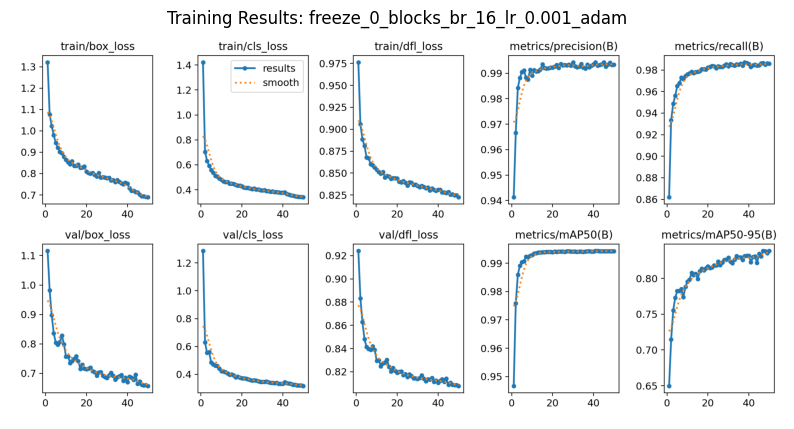

Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1670.3190.2 MB/s, size: 1305.3 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


                   all        200      11906      0.993      0.986      0.994      0.839
Speed: 0.6ms preprocess, 3.8ms inference, 0.0ms loss, 8.6ms postprocess per image
Results saved to yolo_val_metrics\freeze_0_blocks_br_16_lr_0.001_adam
Results saved to yolo_val_predictions\freeze_0_blocks_br_16_lr_0.001_adam
200 labels saved to yolo_val_predictions\freeze_0_blocks_br_16_lr_0.001_adam\labels
[freeze_0_blocks_br_16_lr_0.001_adam - Validation] EMA: 47.00%, MSE: 3.65


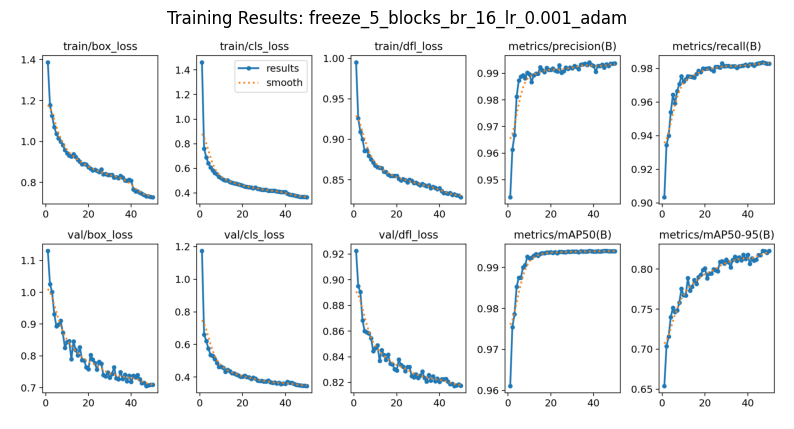

Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1676.5135.8 MB/s, size: 1371.4 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


                   all        200      11906      0.993      0.984      0.994      0.824
Speed: 0.4ms preprocess, 4.5ms inference, 0.0ms loss, 9.1ms postprocess per image
Results saved to yolo_val_metrics\freeze_5_blocks_br_16_lr_0.001_adam
Results saved to yolo_val_predictions\freeze_5_blocks_br_16_lr_0.001_adam
200 labels saved to yolo_val_predictions\freeze_5_blocks_br_16_lr_0.001_adam\labels
[freeze_5_blocks_br_16_lr_0.001_adam - Validation] EMA: 44.50%, MSE: 3.77


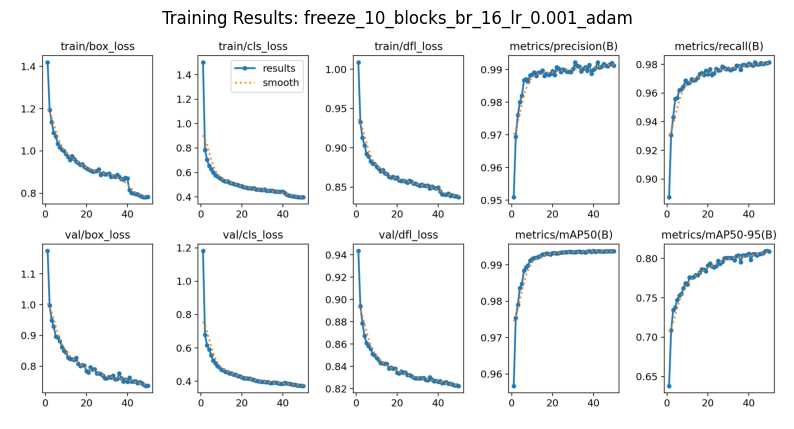

Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 2093.3309.9 MB/s, size: 1339.7 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


                   all        200      11906      0.992      0.981      0.994       0.81
Speed: 0.5ms preprocess, 4.0ms inference, 0.0ms loss, 7.9ms postprocess per image
Results saved to yolo_val_metrics\freeze_10_blocks_br_16_lr_0.001_adam
Results saved to yolo_val_predictions\freeze_10_blocks_br_16_lr_0.001_adam
200 labels saved to yolo_val_predictions\freeze_10_blocks_br_16_lr_0.001_adam\labels
[freeze_10_blocks_br_16_lr_0.001_adam - Validation] EMA: 38.50%, MSE: 6.33


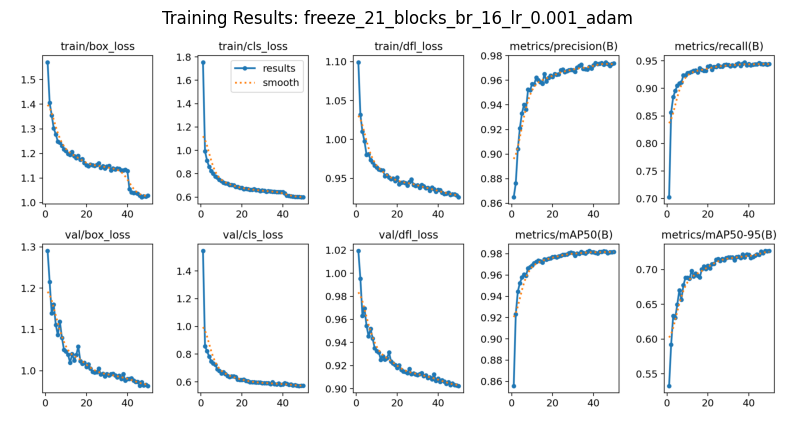

Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 2132.1357.9 MB/s, size: 1395.4 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


                   all        200      11906      0.974      0.944      0.982      0.728
Speed: 0.5ms preprocess, 4.2ms inference, 0.0ms loss, 10.6ms postprocess per image
Results saved to yolo_val_metrics\freeze_21_blocks_br_16_lr_0.001_adam
Results saved to yolo_val_predictions\freeze_21_blocks_br_16_lr_0.001_adam
200 labels saved to yolo_val_predictions\freeze_21_blocks_br_16_lr_0.001_adam\labels
[freeze_21_blocks_br_16_lr_0.001_adam - Validation] EMA: 9.00%, MSE: 105.34

Model Evaluation Summary:


,Model,Precision,Recall,mAP@50,EMA (%),MSE
0,freeze_0_blocks_br_16_lr_0.001_adam,0.993,0.986,0.994,47.0,3.66
1,freeze_5_blocks_br_16_lr_0.001_adam,0.993,0.984,0.994,44.5,3.77
2,freeze_10_blocks_br_16_lr_0.001_adam,0.992,0.981,0.994,38.5,6.32
3,freeze_21_blocks_br_16_lr_0.001_adam,0.974,0.944,0.982,9.0,105.34


In [ ]:
results_freezes = []

for freeze in [0, 5, 10, 21]:
    name = f'freeze_{freeze}_blocks_br_16_lr_0.001_adam'

    show_loss_plots(name)

    model_metrics = evaluate_model(name, split='val')
    predict_model(name, split='val')
    val_counts = evaluate_detection_counts(name, split='val')

    precision = model_metrics.box.p
    recall = model_metrics.box.r
    map50 = model_metrics.box.map50
    ema = val_counts['exact_match_accuracy']
    mse = val_counts['mse']


    print(f"[{name} - Validation] EMA: {ema:.2f}%, MSE: {mse:.2f}")

    results_freezes.append({
        'Model': name,
        'Precision': round(precision[0], 3),
        'Recall': round(recall[0], 3),
        'mAP@50': round(map50, 3),
        'EMA (%)': round(ema, 2),
        'MSE': round(mse, 2)
    })

df_freezes = pd.DataFrame(results_freezes)

print("\nModel Evaluation Summary:")
df_freezes

### Learning Hyperparameter Search for the Best Frozen Model

#### Train the Best Frozen Model with Different Learning Hyperparameters

From the previous section, the best model is selected as the one with unfrozen layers having hyperparameters "Epochs : 50", "Learning Rate : 0.001", "Optimizer : Adam", "Batch Size : 16". In this section, we trained the best model with different hyperparameters. In order to see the changes that these hyperparameters do clearly, it is decided to only change one at a time. We trained 4 different models in this section: first one with changing batch size to 8, second one with changing learning rate to 0.0005, third one with changing optimizer to SGD, and the fourth one with changing the optimizer to SGD and learning rate to 0.01. The reason for the fourth one is to try to see the effect of different learning rates with different optimizers. In theory, Adam optimizer works better with learning rate 0.001 and SGD with learning rate 0.01. The evaluation results for these models can be seen in the next section.

In [22]:
# Batch size 8 with LR 0.001 and Adam optimizer

train_model(
    epochs=50,
    optimizer='Adam',
    lr=0.001,
    batch=8,
    name=f'freeze_0_blocks_br_8_lr_0.001_adam',
    freeze=0
)

New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=freeze_0_blocks_br_8_lr_0.001_adam, 

train: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\train\labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 812.0239.5 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to yolo_models\freeze_0_blocks_br_8_lr_0.001_adam\labels.jpg... 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000018B9DE83B80>
Traceback (most recent call last):
  File "c:\Users\Kayra\anaconda3\envs\conda3-9\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\Kayra\anaconda3\envs\conda3-9\lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_models\freeze_0_blocks_br_8_lr_0.001_adam
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.09G       1.29      1.182     0.9679       1050        640: 100%|██████████| 125/125 [00:23<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.94it/s]

                   all        200      11906       0.94      0.923      0.964        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.93G      1.077     0.6861     0.9038        538        640: 100%|██████████| 125/125 [00:18<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.37it/s]

                   all        200      11906      0.979      0.951      0.984      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.93G      1.008     0.6138      0.889       1229        640: 100%|██████████| 125/125 [00:18<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.51it/s]

                   all        200      11906      0.989      0.955      0.987      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.93G     0.9685     0.5811     0.8812        630        640: 100%|██████████| 125/125 [00:18<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.74it/s]

                   all        200      11906      0.987      0.966       0.99      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.43G     0.9539     0.5573     0.8726        702        640: 100%|██████████| 125/125 [00:19<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.55it/s]

                   all        200      11906      0.991      0.968      0.991      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.32G     0.9268      0.534     0.8706        942        640: 100%|██████████| 125/125 [00:20<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.60it/s]

                   all        200      11906      0.987      0.972      0.992      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.01G     0.9164      0.523     0.8674        704        640: 100%|██████████| 125/125 [00:19<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.71it/s]

                   all        200      11906      0.987      0.975      0.993      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.34G     0.8951     0.5051     0.8625        708        640: 100%|██████████| 125/125 [00:18<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.70it/s]

                   all        200      11906       0.99      0.976      0.993      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.45G     0.8862     0.4935       0.86        890        640: 100%|██████████| 125/125 [00:19<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.20it/s]

                   all        200      11906      0.991      0.976      0.993      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.45G     0.8864      0.486     0.8595        947        640: 100%|██████████| 125/125 [00:19<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.73it/s]

                   all        200      11906      0.991      0.976      0.993      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.27G     0.8699     0.4693     0.8543       1147        640: 100%|██████████| 125/125 [00:19<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.14it/s]

                   all        200      11906      0.991      0.977      0.993      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.03G     0.8522     0.4571     0.8512        837        640: 100%|██████████| 125/125 [00:18<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.16it/s]

                   all        200      11906      0.992       0.98      0.994      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.45G     0.8648     0.4608     0.8534        885        640: 100%|██████████| 125/125 [00:18<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.07it/s]

                   all        200      11906      0.991       0.98      0.994      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.97G     0.8543     0.4521     0.8486        668        640: 100%|██████████| 125/125 [00:18<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.69it/s]

                   all        200      11906      0.992      0.981      0.994       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.19G     0.8482     0.4481     0.8492       1063        640: 100%|██████████| 125/125 [00:19<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.78it/s]

                   all        200      11906      0.993      0.979      0.994      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.04G     0.8311       0.44     0.8467        885        640: 100%|██████████| 125/125 [00:19<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.66it/s]

                   all        200      11906      0.993       0.98      0.994      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       3.1G      0.833     0.4355     0.8464        914        640: 100%|██████████| 125/125 [00:19<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.62it/s]

                   all        200      11906      0.991      0.983      0.994      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.85G     0.8268     0.4316     0.8452        684        640: 100%|██████████| 125/125 [00:19<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.92it/s]

                   all        200      11906      0.991      0.983      0.994      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.31G     0.8281     0.4311     0.8449        678        640: 100%|██████████| 125/125 [00:19<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.92it/s]

                   all        200      11906      0.993      0.982      0.994       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.73G     0.8114     0.4231     0.8453        665        640: 100%|██████████| 125/125 [00:19<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.66it/s]

                   all        200      11906      0.994       0.98      0.994      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.27G     0.8194     0.4214     0.8438       1080        640: 100%|██████████| 125/125 [00:18<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.83it/s]

                   all        200      11906      0.992       0.98      0.994      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.01G     0.8105      0.421     0.8443        766        640: 100%|██████████| 125/125 [00:20<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.02it/s]

                   all        200      11906      0.993      0.981      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.75G     0.8036     0.4159     0.8435       1005        640: 100%|██████████| 125/125 [00:19<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.00it/s]

                   all        200      11906      0.993      0.984      0.994      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.43G     0.8017     0.4133     0.8411        768        640: 100%|██████████| 125/125 [00:19<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.74it/s]

                   all        200      11906      0.992      0.984      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.44G     0.7984      0.407     0.8398       1036        640: 100%|██████████| 125/125 [00:19<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.80it/s]

                   all        200      11906      0.991      0.985      0.994      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.29G     0.7985     0.4075     0.8404       1146        640: 100%|██████████| 125/125 [00:18<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.14it/s]

                   all        200      11906      0.992      0.981      0.994      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.23G     0.7818     0.3997     0.8401        699        640: 100%|██████████| 125/125 [00:18<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.44it/s]

                   all        200      11906      0.992      0.985      0.994      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.97G     0.7912     0.4018     0.8388        782        640: 100%|██████████| 125/125 [00:17<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.30it/s]

                   all        200      11906      0.994      0.983      0.994      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.39G     0.7858     0.3998     0.8377        733        640: 100%|██████████| 125/125 [00:17<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.61it/s]

                   all        200      11906      0.994      0.983      0.994      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.25G     0.7834     0.3954     0.8366        857        640: 100%|██████████| 125/125 [00:18<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.54it/s]

                   all        200      11906      0.994      0.983      0.994       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.18G     0.7778      0.392     0.8363        840        640: 100%|██████████| 125/125 [00:18<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.06it/s]

                   all        200      11906      0.993      0.984      0.994      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.08G     0.7679     0.3892     0.8364        874        640: 100%|██████████| 125/125 [00:19<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.34it/s]

                   all        200      11906      0.993      0.985      0.994      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.13G     0.7708     0.3867     0.8358        762        640: 100%|██████████| 125/125 [00:17<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.60it/s]

                   all        200      11906      0.994      0.983      0.994      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.37G     0.7676     0.3862     0.8347       1259        640: 100%|██████████| 125/125 [00:18<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.51it/s]

                   all        200      11906      0.993      0.985      0.994      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.39G     0.7667     0.3847     0.8348        542        640: 100%|██████████| 125/125 [00:18<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.53it/s]

                   all        200      11906      0.993      0.985      0.994      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.39G     0.7697     0.3867     0.8322        981        640: 100%|██████████| 125/125 [00:18<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.55it/s]

                   all        200      11906      0.993      0.985      0.994      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.08G     0.7629     0.3816     0.8329        809        640: 100%|██████████| 125/125 [00:18<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.43it/s]

                   all        200      11906      0.993      0.985      0.994      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       2.8G     0.7584     0.3792     0.8326        547        640: 100%|██████████| 125/125 [00:18<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.74it/s]

                   all        200      11906      0.992      0.985      0.994      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.8G      0.757      0.377     0.8322        732        640: 100%|██████████| 125/125 [00:18<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.25it/s]

                   all        200      11906      0.995      0.983      0.994      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       2.8G      0.754     0.3755     0.8326       1063        640: 100%|██████████| 125/125 [00:18<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.12it/s]

                   all        200      11906      0.994      0.986      0.994      0.832


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       2.8G     0.7404      0.373     0.8318        679        640: 100%|██████████| 125/125 [00:17<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.14it/s]

                   all        200      11906      0.994      0.985      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.8G     0.7268     0.3624     0.8293        643        640: 100%|██████████| 125/125 [00:16<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.41it/s]

                   all        200      11906      0.995      0.984      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       2.8G     0.7179     0.3584     0.8289        512        640: 100%|██████████| 125/125 [00:17<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.16it/s]

                   all        200      11906      0.994      0.985      0.994      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       2.8G     0.7081     0.3509     0.8265        441        640: 100%|██████████| 125/125 [00:17<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.29it/s]

                   all        200      11906      0.993      0.986      0.994      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       2.8G     0.7143     0.3517     0.8275        450        640: 100%|██████████| 125/125 [00:17<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.20it/s]

                   all        200      11906      0.994      0.985      0.994      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       2.8G     0.7052     0.3478     0.8268        446        640: 100%|██████████| 125/125 [00:17<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.33it/s]

                   all        200      11906      0.994      0.984      0.994      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.8G      0.701      0.346     0.8268        429        640: 100%|██████████| 125/125 [00:16<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.39it/s]

                   all        200      11906      0.993      0.987      0.994      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       2.8G     0.7011     0.3435     0.8267        712        640: 100%|██████████| 125/125 [00:17<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.89it/s]

                   all        200      11906      0.995      0.985      0.994       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       2.8G     0.6983     0.3417     0.8256        581        640: 100%|██████████| 125/125 [00:19<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.78it/s]

                   all        200      11906      0.993      0.987      0.994       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       2.8G     0.6935     0.3397     0.8238        616        640: 100%|██████████| 125/125 [00:18<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.95it/s]

                   all        200      11906      0.993      0.985      0.994      0.842



50 epochs completed in 0.305 hours.
Optimizer stripped from yolo_models\freeze_0_blocks_br_8_lr_0.001_adam\weights\last.pt, 6.2MB
Optimizer stripped from yolo_models\freeze_0_blocks_br_8_lr_0.001_adam\weights\best.pt, 6.2MB

Validating yolo_models\freeze_0_blocks_br_8_lr_0.001_adam\weights\best.pt...
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


                   all        200      11906      0.993      0.985      0.994      0.842
Speed: 0.4ms preprocess, 4.2ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to yolo_models\freeze_0_blocks_br_8_lr_0.001_adam
Training completed for model: freeze_0_blocks_br_8_lr_0.001_adam


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [23]:
# Batch size 16 with LR 0.0005 and Adam optimizer

train_model(
    epochs=50,
    optimizer='Adam',
    lr=0.001,
    batch=8,
    name=f'freeze_0_blocks_br_16_lr_0.0005_adam',
    freeze=0
)

New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=freeze_0_blocks_br_16_lr_0.0005_adam

train: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\train\labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 1233.4172.2 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to yolo_models\freeze_0_blocks_br_16_lr_0.0005_adam\labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_models\freeze_0_blocks_br_16_lr_0.0005_adam
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.13G       1.29      1.182     0.9679       1050        640: 100%|██████████| 125/125 [00:23<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.40it/s]


                   all        200      11906       0.94      0.923      0.964        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         3G      1.077     0.6861     0.9038        538        640: 100%|██████████| 125/125 [00:19<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.42it/s]

                   all        200      11906      0.979      0.951      0.984      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         3G      1.008     0.6138      0.889       1229        640: 100%|██████████| 125/125 [00:19<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.46it/s]

                   all        200      11906      0.989      0.955      0.987      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         3G     0.9685     0.5811     0.8812        630        640: 100%|██████████| 125/125 [00:18<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.51it/s]

                   all        200      11906      0.987      0.966       0.99      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.49G     0.9539     0.5573     0.8726        702        640: 100%|██████████| 125/125 [00:19<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.64it/s]

                   all        200      11906      0.991      0.968      0.991      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.38G     0.9268      0.534     0.8706        942        640: 100%|██████████| 125/125 [00:17<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.11it/s]

                   all        200      11906      0.987      0.972      0.992      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.07G     0.9164      0.523     0.8674        704        640: 100%|██████████| 125/125 [00:18<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.77it/s]

                   all        200      11906      0.987      0.975      0.993      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       3.4G     0.8951     0.5051     0.8625        708        640: 100%|██████████| 125/125 [00:18<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.45it/s]

                   all        200      11906       0.99      0.976      0.993      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       2.5G     0.8862     0.4935       0.86        890        640: 100%|██████████| 125/125 [00:19<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.75it/s]

                   all        200      11906      0.991      0.976      0.993      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       2.5G     0.8864      0.486     0.8595        947        640: 100%|██████████| 125/125 [00:19<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.30it/s]

                   all        200      11906      0.991      0.976      0.993      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.33G     0.8699     0.4693     0.8543       1147        640: 100%|██████████| 125/125 [00:20<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.67it/s]

                   all        200      11906      0.991      0.977      0.993      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.09G     0.8522     0.4571     0.8512        837        640: 100%|██████████| 125/125 [00:19<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.75it/s]

                   all        200      11906      0.992       0.98      0.994      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.51G     0.8648     0.4608     0.8534        885        640: 100%|██████████| 125/125 [00:19<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.08it/s]

                   all        200      11906      0.991       0.98      0.994      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.02G     0.8543     0.4521     0.8486        668        640: 100%|██████████| 125/125 [00:18<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.76it/s]

                   all        200      11906      0.992      0.981      0.994       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.24G     0.8482     0.4481     0.8492       1063        640: 100%|██████████| 125/125 [00:18<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.11it/s]

                   all        200      11906      0.993      0.979      0.994      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.09G     0.8311       0.44     0.8467        885        640: 100%|██████████| 125/125 [00:17<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.93it/s]

                   all        200      11906      0.993       0.98      0.994      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.16G      0.833     0.4355     0.8464        914        640: 100%|██████████| 125/125 [00:17<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.20it/s]

                   all        200      11906      0.991      0.983      0.994      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.91G     0.8268     0.4316     0.8452        684        640: 100%|██████████| 125/125 [00:18<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.41it/s]

                   all        200      11906      0.991      0.983      0.994      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.37G     0.8281     0.4311     0.8449        678        640: 100%|██████████| 125/125 [00:19<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.88it/s]

                   all        200      11906      0.993      0.982      0.994       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.79G     0.8114     0.4231     0.8453        665        640: 100%|██████████| 125/125 [00:19<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.87it/s]

                   all        200      11906      0.994       0.98      0.994      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.34G     0.8194     0.4214     0.8438       1080        640: 100%|██████████| 125/125 [00:18<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.12it/s]

                   all        200      11906      0.992       0.98      0.994      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.07G     0.8105      0.421     0.8443        766        640: 100%|██████████| 125/125 [00:18<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.33it/s]

                   all        200      11906      0.993      0.981      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.81G     0.8036     0.4159     0.8435       1005        640: 100%|██████████| 125/125 [00:18<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.25it/s]

                   all        200      11906      0.993      0.984      0.994      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.49G     0.8017     0.4133     0.8411        768        640: 100%|██████████| 125/125 [00:18<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.12it/s]

                   all        200      11906      0.992      0.984      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.49G     0.7984      0.407     0.8398       1036        640: 100%|██████████| 125/125 [00:18<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.22it/s]

                   all        200      11906      0.991      0.985      0.994      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.34G     0.7985     0.4075     0.8404       1146        640: 100%|██████████| 125/125 [00:18<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.03it/s]

                   all        200      11906      0.992      0.981      0.994      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.29G     0.7818     0.3997     0.8401        699        640: 100%|██████████| 125/125 [00:19<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.73it/s]

                   all        200      11906      0.992      0.985      0.994      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.03G     0.7912     0.4018     0.8388        782        640: 100%|██████████| 125/125 [00:18<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.50it/s]

                   all        200      11906      0.994      0.983      0.994      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.28G     0.7858     0.3998     0.8377        733        640: 100%|██████████| 125/125 [00:18<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.13it/s]

                   all        200      11906      0.994      0.983      0.994      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       3.3G     0.7834     0.3954     0.8366        857        640: 100%|██████████| 125/125 [00:17<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.60it/s]

                   all        200      11906      0.994      0.983      0.994       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.24G     0.7778      0.392     0.8363        840        640: 100%|██████████| 125/125 [00:18<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.30it/s]

                   all        200      11906      0.993      0.984      0.994      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.14G     0.7679     0.3892     0.8364        874        640: 100%|██████████| 125/125 [00:17<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]

                   all        200      11906      0.993      0.985      0.994      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.19G     0.7708     0.3867     0.8358        762        640: 100%|██████████| 125/125 [00:19<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.36it/s]

                   all        200      11906      0.994      0.983      0.994      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.42G     0.7676     0.3862     0.8347       1259        640: 100%|██████████| 125/125 [00:18<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.59it/s]

                   all        200      11906      0.993      0.985      0.994      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.45G     0.7667     0.3847     0.8348        542        640: 100%|██████████| 125/125 [00:17<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        200      11906      0.993      0.985      0.994      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.45G     0.7697     0.3867     0.8322        981        640: 100%|██████████| 125/125 [00:17<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.15it/s]

                   all        200      11906      0.993      0.985      0.994      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.14G     0.7629     0.3816     0.8329        809        640: 100%|██████████| 125/125 [00:17<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.59it/s]

                   all        200      11906      0.993      0.985      0.994      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.86G     0.7584     0.3792     0.8326        547        640: 100%|██████████| 125/125 [00:17<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.50it/s]

                   all        200      11906      0.992      0.985      0.994      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.86G      0.757      0.377     0.8322        732        640: 100%|██████████| 125/125 [00:18<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]

                   all        200      11906      0.995      0.983      0.994      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.86G      0.754     0.3755     0.8326       1063        640: 100%|██████████| 125/125 [00:18<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.52it/s]

                   all        200      11906      0.994      0.986      0.994      0.832


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.86G     0.7404      0.373     0.8318        679        640: 100%|██████████| 125/125 [00:17<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.36it/s]

                   all        200      11906      0.994      0.985      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.86G     0.7268     0.3624     0.8293        643        640: 100%|██████████| 125/125 [00:16<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.68it/s]

                   all        200      11906      0.995      0.984      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.86G     0.7179     0.3584     0.8289        512        640: 100%|██████████| 125/125 [00:16<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.53it/s]

                   all        200      11906      0.994      0.985      0.994      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.86G     0.7081     0.3509     0.8265        441        640: 100%|██████████| 125/125 [00:17<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.74it/s]

                   all        200      11906      0.993      0.986      0.994      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.86G     0.7143     0.3517     0.8275        450        640: 100%|██████████| 125/125 [00:16<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        200      11906      0.994      0.985      0.994      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.86G     0.7052     0.3478     0.8268        446        640: 100%|██████████| 125/125 [00:16<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]

                   all        200      11906      0.994      0.984      0.994      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.86G      0.701      0.346     0.8268        429        640: 100%|██████████| 125/125 [00:17<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.98it/s]

                   all        200      11906      0.993      0.987      0.994      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.86G     0.7011     0.3435     0.8267        712        640: 100%|██████████| 125/125 [00:17<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]

                   all        200      11906      0.995      0.985      0.994       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.86G     0.6983     0.3417     0.8256        581        640: 100%|██████████| 125/125 [00:18<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.97it/s]

                   all        200      11906      0.993      0.987      0.994       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.86G     0.6935     0.3397     0.8238        616        640: 100%|██████████| 125/125 [00:17<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.10it/s]

                   all        200      11906      0.993      0.985      0.994      0.842



50 epochs completed in 0.301 hours.
Optimizer stripped from yolo_models\freeze_0_blocks_br_16_lr_0.0005_adam\weights\last.pt, 6.2MB
Optimizer stripped from yolo_models\freeze_0_blocks_br_16_lr_0.0005_adam\weights\best.pt, 6.2MB

Validating yolo_models\freeze_0_blocks_br_16_lr_0.0005_adam\weights\best.pt...
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


                   all        200      11906      0.993      0.985      0.994      0.842
Speed: 0.3ms preprocess, 3.0ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to yolo_models\freeze_0_blocks_br_16_lr_0.0005_adam
Training completed for model: freeze_0_blocks_br_16_lr_0.0005_adam


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [24]:
# Batch size 16 with LR 0.001 and SGD optimizer

train_model(
    epochs=50,
    optimizer='SGD',
    lr=0.001,
    batch=16,
    name='freeze_0_blocks_br_16_lr_0.001_sgd',
    freeze=0
)

New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=freeze_0_blocks_br_16_lr_0.001_sgd,

train: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\train\labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 561.5172.2 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to yolo_models\freeze_0_blocks_br_16_lr_0.001_sgd\labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_models\freeze_0_blocks_br_16_lr_0.001_sgd
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.13G      1.482      2.214      1.104       1118        640: 100%|██████████| 63/63 [00:29<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.95it/s]

                   all        200      11906       0.89      0.799      0.908      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.85G      1.208     0.9404     0.9837        787        640: 100%|██████████| 63/63 [00:14<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        200      11906      0.949      0.899      0.962      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       4.8G      1.124     0.7535     0.9476        870        640: 100%|██████████| 63/63 [00:13<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        200      11906      0.958      0.931      0.973      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.21G      1.057     0.6893     0.9296        669        640: 100%|██████████| 63/63 [00:12<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]

                   all        200      11906      0.968      0.942      0.978      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.85G      1.025     0.6522     0.9124        908        640: 100%|██████████| 63/63 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]

                   all        200      11906      0.969      0.949       0.98      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.06G      0.991     0.6278     0.9089        585        640: 100%|██████████| 63/63 [00:42<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        200      11906      0.981      0.952      0.982       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       4.9G     0.9781     0.6049     0.9005        922        640: 100%|██████████| 63/63 [00:12<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]

                   all        200      11906      0.984      0.949      0.982       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.48G     0.9621     0.6002     0.8969        766        640: 100%|██████████| 63/63 [00:13<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]

                   all        200      11906      0.987      0.952      0.984      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.02G     0.9496     0.5865     0.8938        900        640: 100%|██████████| 63/63 [00:15<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.87it/s]

                   all        200      11906      0.986      0.956      0.985      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.15G     0.9409     0.5807     0.8906       1024        640: 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


                   all        200      11906      0.988      0.957      0.986      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.88G     0.9318     0.5685     0.8877        902        640: 100%|██████████| 63/63 [00:14<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        200      11906      0.989      0.959      0.987      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         6G     0.9184     0.5611     0.8847        736        640: 100%|██████████| 63/63 [00:14<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]

                   all        200      11906      0.989       0.96      0.988      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.65G     0.9273     0.5633     0.8855       1119        640: 100%|██████████| 63/63 [00:12<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        200      11906      0.989      0.963      0.989      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.79G     0.9168     0.5517     0.8797        931        640: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


                   all        200      11906      0.988      0.961      0.988      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.72G     0.9052      0.549     0.8794        983        640: 100%|██████████| 63/63 [00:13<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        200      11906      0.989      0.965      0.989      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.21G     0.9089      0.545     0.8771       1080        640: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]

                   all        200      11906      0.988      0.964       0.99      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.96G     0.8937     0.5349     0.8755        827        640: 100%|██████████| 63/63 [00:17<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        200      11906       0.99      0.965       0.99      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.88G     0.9013     0.5371     0.8764        843        640: 100%|██████████| 63/63 [00:13<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        200      11906       0.99      0.966      0.991       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.27G     0.8924     0.5304     0.8748        718        640: 100%|██████████| 63/63 [00:12<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]

                   all        200      11906       0.99      0.966      0.991      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.59G     0.8819     0.5298      0.877        772        640: 100%|██████████| 63/63 [00:12<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]

                   all        200      11906      0.989      0.969      0.991      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.79G     0.8744     0.5186     0.8704        949        640: 100%|██████████| 63/63 [00:13<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

                   all        200      11906      0.989      0.967      0.991      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       4.2G     0.8752     0.5198     0.8712       1063        640: 100%|██████████| 63/63 [00:12<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

                   all        200      11906      0.991      0.969      0.992      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.56G     0.8771     0.5213     0.8722       1217        640: 100%|██████████| 63/63 [00:12<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

                   all        200      11906       0.99      0.969      0.991      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.36G     0.8708     0.5141     0.8704        502        640: 100%|██████████| 63/63 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]

                   all        200      11906      0.989      0.969      0.991      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       7.6G     0.8661     0.5094     0.8663        857        640: 100%|██████████| 63/63 [00:27<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


                   all        200      11906       0.99      0.971      0.992      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         6G     0.8769     0.5148     0.8702        986        640: 100%|██████████| 63/63 [00:14<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.95it/s]

                   all        200      11906       0.99      0.971      0.992      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.02G     0.8612     0.5072     0.8717        908        640: 100%|██████████| 63/63 [00:14<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]

                   all        200      11906      0.991      0.972      0.992        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.44G     0.8663     0.5081     0.8673        914        640: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        200      11906      0.992      0.972      0.992      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.63G     0.8614     0.5006     0.8683        730        640: 100%|██████████| 63/63 [00:12<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]

                   all        200      11906      0.992      0.971      0.992      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.16G     0.8615     0.4999     0.8663        709        640: 100%|██████████| 63/63 [00:12<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]

                   all        200      11906      0.992      0.972      0.992      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.03G     0.8674     0.5038     0.8654       1028        640: 100%|██████████| 63/63 [00:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        200      11906      0.992      0.973      0.992      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.37G     0.8507     0.4923     0.8673        797        640: 100%|██████████| 63/63 [00:12<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

                   all        200      11906      0.991      0.972      0.992      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.96G     0.8538     0.4961     0.8667        935        640: 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

                   all        200      11906      0.992      0.973      0.993      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.66G     0.8494     0.4954     0.8644       1109        640: 100%|██████████| 63/63 [00:12<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]

                   all        200      11906      0.992      0.973      0.993      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.57G     0.8573     0.4925     0.8651        949        640: 100%|██████████| 63/63 [00:24<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        200      11906      0.992      0.973      0.993      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.36G     0.8516     0.4906     0.8617        800        640: 100%|██████████| 63/63 [00:12<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        200      11906      0.993      0.972      0.993      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.45G     0.8422     0.4878     0.8633        895        640: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]

                   all        200      11906      0.993      0.973      0.993      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.56G     0.8461     0.4888     0.8636        863        640: 100%|██████████| 63/63 [00:17<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


                   all        200      11906      0.993      0.973      0.993      0.807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.85G     0.8506      0.488     0.8614       1134        640: 100%|██████████| 63/63 [00:13<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]

                   all        200      11906      0.993      0.974      0.993      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         6G     0.8454     0.4874     0.8632        719        640: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        200      11906      0.993      0.973      0.993      0.804


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       3.8G     0.8328     0.5679     0.8695        667        640: 100%|██████████| 63/63 [00:12<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


                   all        200      11906       0.99      0.974      0.993      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.05G     0.8143     0.5138     0.8637        629        640: 100%|██████████| 63/63 [00:11<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]

                   all        200      11906      0.991      0.974      0.993      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.43G     0.8114     0.4974     0.8633        500        640: 100%|██████████| 63/63 [00:11<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        200      11906      0.991      0.973      0.993      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.19G     0.8025     0.4903     0.8615        441        640: 100%|██████████| 63/63 [00:11<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        200      11906      0.991      0.974      0.993      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.42G     0.8025     0.4878     0.8636        447        640: 100%|██████████| 63/63 [00:11<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

                   all        200      11906      0.991      0.974      0.993      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.43G     0.7952     0.4834     0.8609        444        640: 100%|██████████| 63/63 [00:11<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.33it/s]

                   all        200      11906      0.991      0.973      0.993      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.02G     0.7878     0.4789     0.8621        431        640: 100%|██████████| 63/63 [00:11<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]

                   all        200      11906       0.99      0.974      0.993      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.56G     0.7899     0.4788     0.8605        712        640: 100%|██████████| 63/63 [00:11<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        200      11906       0.99      0.974      0.993      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.21G     0.7903     0.4794     0.8612        601        640: 100%|██████████| 63/63 [00:11<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        200      11906      0.991      0.973      0.993      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.28G     0.7914     0.4761      0.858        611        640: 100%|██████████| 63/63 [00:11<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        200      11906      0.991      0.973      0.993      0.807



50 epochs completed in 0.267 hours.
Optimizer stripped from yolo_models\freeze_0_blocks_br_16_lr_0.001_sgd\weights\last.pt, 6.2MB
Optimizer stripped from yolo_models\freeze_0_blocks_br_16_lr_0.001_sgd\weights\best.pt, 6.2MB

Validating yolo_models\freeze_0_blocks_br_16_lr_0.001_sgd\weights\best.pt...
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


                   all        200      11906      0.992      0.973      0.993      0.807
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 11.8ms postprocess per image
Results saved to yolo_models\freeze_0_blocks_br_16_lr_0.001_sgd
Training completed for model: freeze_0_blocks_br_16_lr_0.001_sgd


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [5]:
# Batch size 16 with LR 0.01 and SGD optimizer

train_model(
    epochs=50,
    optimizer='SGD',
    lr=0.01,
    batch=16,
    name='freeze_0_blocks_br_16_lr_0.01_sgd',
    freeze=0
)

New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=freeze_0_blocks_br_16_lr_0.01_sgd, n

train: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\train\labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.0 ms, read: 820.188.8 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to yolo_models\freeze_0_blocks_br_16_lr_0.01_sgd\labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_models\freeze_0_blocks_br_16_lr_0.01_sgd
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.02G      1.344      1.612      1.033       1118        640: 100%|██████████| 63/63 [00:28<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

                   all        200      11906      0.971      0.883      0.964      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.73G        1.2     0.7518     0.9541        787        640: 100%|██████████| 63/63 [00:13<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]

                   all        200      11906      0.974      0.934      0.976      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.68G      1.254     0.7422     0.9587        870        640: 100%|██████████| 63/63 [00:13<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]

                   all        200      11906       0.98      0.947       0.98      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.11G      1.236     0.7178     0.9565        669        640: 100%|██████████| 63/63 [00:12<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        200      11906      0.979       0.95      0.982      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.47G      1.161     0.6836     0.9309        908        640: 100%|██████████| 63/63 [00:12<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]

                   all        200      11906      0.989      0.955      0.987      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.96G      1.103     0.6411     0.9222        585        640: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]

                   all        200      11906      0.988      0.963       0.99      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.78G      1.076     0.6002     0.9103        922        640: 100%|██████████| 63/63 [00:12<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        200      11906      0.988      0.961      0.989      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.38G      1.038     0.5889     0.9013        766        640: 100%|██████████| 63/63 [00:12<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        200      11906      0.991      0.968      0.992      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.91G      1.013     0.5618     0.8963        900        640: 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        200      11906       0.99      0.973      0.992      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.04G      1.001     0.5435     0.8919       1024        640: 100%|██████████| 63/63 [00:17<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        200      11906      0.991      0.972      0.993       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.78G     0.9698     0.5331     0.8868        902        640: 100%|██████████| 63/63 [00:13<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        200      11906      0.993      0.973      0.993      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       5.9G     0.9536     0.5185     0.8812        736        640: 100%|██████████| 63/63 [00:13<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        200      11906      0.992      0.975      0.993      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.54G      0.949      0.517     0.8805       1119        640: 100%|██████████| 63/63 [00:12<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        200      11906       0.99      0.978      0.993      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.66G     0.9403      0.501     0.8762        931        640: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        200      11906      0.992      0.977      0.993      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.35G     0.9215     0.4991     0.8744        983        640: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        200      11906      0.992      0.977      0.993      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       5.1G     0.9197     0.4863       0.87       1080        640: 100%|██████████| 63/63 [00:12<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        200      11906      0.993      0.976      0.993      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       6.8G     0.8978     0.4752     0.8669        827        640: 100%|██████████| 63/63 [00:16<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        200      11906      0.992       0.98      0.994      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.78G     0.9002     0.4743     0.8674        843        640: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        200      11906      0.992       0.98      0.994      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.17G     0.8818     0.4636     0.8647        718        640: 100%|██████████| 63/63 [00:12<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        200      11906       0.99      0.982      0.994      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.49G     0.8742     0.4603     0.8678        772        640: 100%|██████████| 63/63 [00:12<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        200      11906      0.992      0.979      0.994      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.68G     0.8651     0.4515     0.8606        949        640: 100%|██████████| 63/63 [00:12<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        200      11906      0.994       0.98      0.994      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.09G     0.8547     0.4489     0.8593       1063        640: 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        200      11906      0.994       0.98      0.994      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.46G     0.8535     0.4504     0.8603       1217        640: 100%|██████████| 63/63 [00:12<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200      11906      0.992      0.981      0.994      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.26G     0.8469     0.4441     0.8577        502        640: 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        200      11906      0.993      0.981      0.994      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.37G     0.8385     0.4369     0.8532        857        640: 100%|██████████| 63/63 [00:20<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200      11906      0.994       0.98      0.994      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.89G     0.8397      0.437      0.856        986        640: 100%|██████████| 63/63 [00:13<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        200      11906      0.993      0.981      0.994      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.91G     0.8202     0.4282     0.8565        908        640: 100%|██████████| 63/63 [00:13<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        200      11906      0.993      0.982      0.994      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.34G     0.8301     0.4303     0.8527        914        640: 100%|██████████| 63/63 [00:14<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        200      11906      0.993      0.981      0.994      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.52G     0.8168     0.4221     0.8526        730        640: 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        200      11906      0.992      0.983      0.994       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.06G     0.8128     0.4209      0.851        709        640: 100%|██████████| 63/63 [00:12<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        200      11906      0.994      0.982      0.994       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.93G     0.8166     0.4248     0.8485       1028        640: 100%|██████████| 63/63 [00:31<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]

                   all        200      11906      0.993      0.983      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.27G     0.7989     0.4146     0.8502        797        640: 100%|██████████| 63/63 [00:14<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        200      11906      0.991      0.984      0.994      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.86G     0.7987     0.4169      0.849        935        640: 100%|██████████| 63/63 [00:12<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        200      11906      0.994      0.982      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.26G     0.7896     0.4127     0.8463       1109        640: 100%|██████████| 63/63 [00:12<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        200      11906      0.994      0.983      0.994      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.47G     0.7958     0.4083     0.8475        949        640: 100%|██████████| 63/63 [00:23<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        200      11906      0.993      0.983      0.994      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.26G      0.788     0.4056     0.8432        800        640: 100%|██████████| 63/63 [00:12<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        200      11906      0.993      0.983      0.994      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.35G     0.7772     0.4031     0.8448        895        640: 100%|██████████| 63/63 [00:23<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        200      11906      0.994      0.982      0.994      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.46G     0.7746     0.4008     0.8438        863        640: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        200      11906      0.993      0.983      0.994      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.74G     0.7777      0.399     0.8418       1134        640: 100%|██████████| 63/63 [00:13<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        200      11906      0.992      0.983      0.994      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.89G     0.7719     0.3975     0.8434        719        640: 100%|██████████| 63/63 [00:15<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        200      11906      0.995      0.982      0.994      0.825


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       3.7G     0.7418     0.3877     0.8463        667        640: 100%|██████████| 63/63 [00:11<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        200      11906      0.994      0.982      0.994      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.95G     0.7286     0.3758     0.8426        629        640: 100%|██████████| 63/63 [00:11<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        200      11906      0.992      0.984      0.994      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.33G     0.7276     0.3734     0.8424        500        640: 100%|██████████| 63/63 [00:11<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        200      11906      0.992      0.983      0.994      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.09G     0.7216       0.37     0.8408        441        640: 100%|██████████| 63/63 [00:11<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        200      11906      0.993      0.983      0.994      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.32G      0.718     0.3663     0.8424        447        640: 100%|██████████| 63/63 [00:11<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        200      11906      0.993      0.984      0.994      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.32G     0.7112     0.3636     0.8391        444        640: 100%|██████████| 63/63 [00:11<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        200      11906      0.991      0.985      0.994      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.92G     0.7059     0.3602     0.8404        431        640: 100%|██████████| 63/63 [00:11<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        200      11906      0.993      0.984      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.46G     0.7057     0.3587     0.8386        712        640: 100%|██████████| 63/63 [00:11<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        200      11906      0.993      0.984      0.994      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       3.1G     0.7041     0.3593     0.8388        601        640: 100%|██████████| 63/63 [00:11<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        200      11906      0.993      0.984      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.17G     0.7015     0.3567     0.8356        611        640: 100%|██████████| 63/63 [00:11<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        200      11906      0.993      0.983      0.994       0.83



50 epochs completed in 0.257 hours.
Optimizer stripped from yolo_models\freeze_0_blocks_br_16_lr_0.01_sgd\weights\last.pt, 6.2MB
Optimizer stripped from yolo_models\freeze_0_blocks_br_16_lr_0.01_sgd\weights\best.pt, 6.2MB

Validating yolo_models\freeze_0_blocks_br_16_lr_0.01_sgd\weights\best.pt...
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


                   all        200      11906      0.993      0.983      0.994       0.83
Speed: 0.5ms preprocess, 2.3ms inference, 0.0ms loss, 10.1ms postprocess per image
Results saved to yolo_models\freeze_0_blocks_br_16_lr_0.01_sgd
Training completed for model: freeze_0_blocks_br_16_lr_0.01_sgd


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

#### Evaluate the Best Frozen Model with Different Learning Hyperparameters

In this section, the models trained in the previous section is evaluated using validation dataset using metrics Precision, Recall, mAP@50, Exact Match Accuracy (EMA), and Mean Squared Error (MSE).

When we look at the evaluation results, we can see that changing the batch size from 16 to 8 (Model 1) and lowering the learning rate to 0.0005 with Adam did not have meaningful changes on detection metrics or exact match accuracy. Both maintained very high precision (0.993), recall (0.986), and mAP@50 (0.994),  while maintaining the same EMA (%47.0) as the baseline model. There is a slight increase in MSE comparing to the baseline model (3.66 to 4.18) which is negligible. However we can still observe the changes that these parameters have done in the training process. Lowering the batch size resulted in less GPU VRAM usage which is a limited resource when training CNN models. Lowering the learning rate resulted in a later convergence comparing to the baseline's training, however they still converged around the same point within 50 epochs.

Using SGD with the original learning rate of 0.001 (Model 3) resulted in a little drop in recall (from 0.986 to 0.973) and a significant drop in EMA (from %47 to %32.5). MSE also increased expectedly to 20.45, indicating less stable and less accurate counting performance. This suggests that the learning rate was likely too low for SGD to fully optimize the model.

When we increased the learning rate to 0.01 while still using SGD (Model 4), we were able to see the improvement over the metrics compared to the previous model (Model 3). Precision and recall went up to 0.994 and 0.983 respectively, and EMA improved to %41.5, being closer to the our baseline. The MSE dropped back to 4.21, showing improved stability. This is also consistent with the theorotical expectations that SGD needs higher learning rates than Adam optimizer to train the CNN effectively.

In summary, our baseline model stayed the best among all the models trained in this section. The changing of learning rate and batch size affected only the training process, it did not have significant effect on the evaluation metrics. The selection of optimizer and its compatible learning rate play a crucial role in achieving optimal detection and counting accuracy.

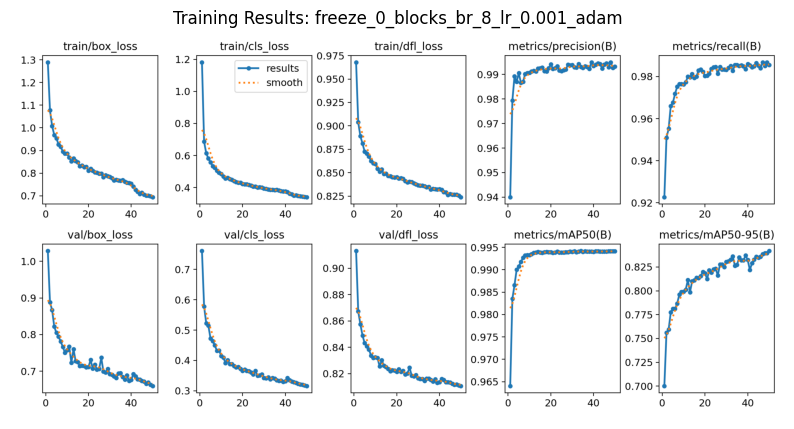

Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1849.3137.6 MB/s, size: 1191.8 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


                   all        200      11906      0.993      0.986      0.994      0.843
Speed: 0.5ms preprocess, 6.5ms inference, 0.0ms loss, 11.0ms postprocess per image
Results saved to yolo_val_metrics\freeze_0_blocks_br_8_lr_0.001_adam
Results saved to yolo_val_predictions\freeze_0_blocks_br_8_lr_0.001_adam
200 labels saved to yolo_val_predictions\freeze_0_blocks_br_8_lr_0.001_adam\labels
[freeze_0_blocks_br_8_lr_0.001_adam - Validation] EMA: 47.00%, MSE: 4.17


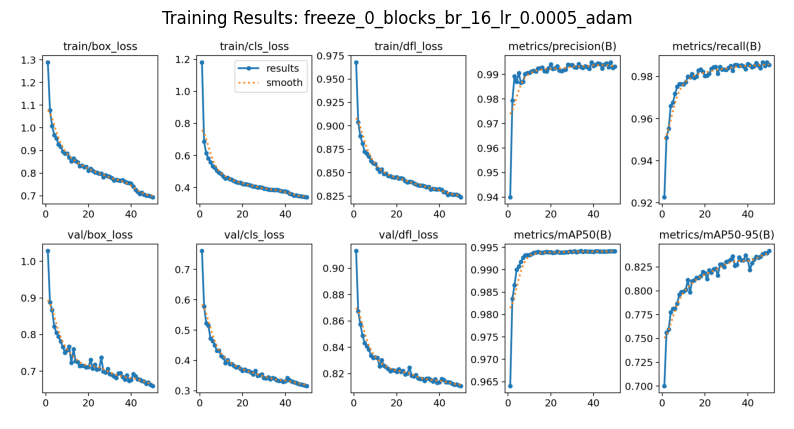

Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1903.2132.5 MB/s, size: 1382.5 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]


                   all        200      11906      0.993      0.986      0.994      0.843
Speed: 0.6ms preprocess, 4.6ms inference, 0.0ms loss, 11.0ms postprocess per image
Results saved to yolo_val_metrics\freeze_0_blocks_br_16_lr_0.0005_adam
Results saved to yolo_val_predictions\freeze_0_blocks_br_16_lr_0.0005_adam
200 labels saved to yolo_val_predictions\freeze_0_blocks_br_16_lr_0.0005_adam\labels
[freeze_0_blocks_br_16_lr_0.0005_adam - Validation] EMA: 47.00%, MSE: 4.17


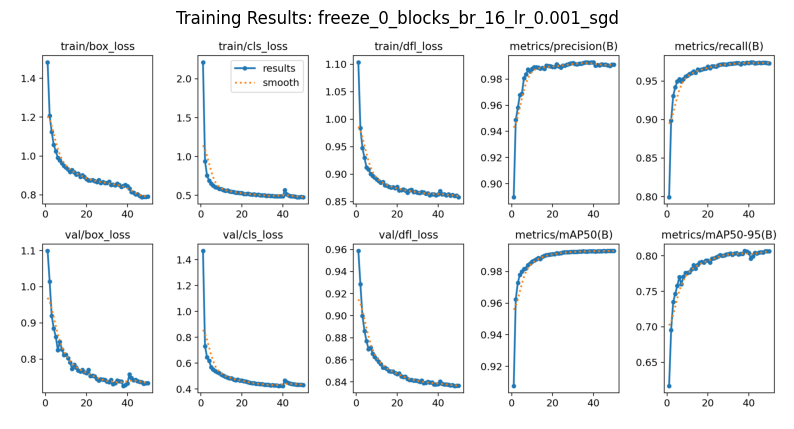

Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1983.5310.9 MB/s, size: 1436.7 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


                   all        200      11906      0.993      0.973      0.993      0.808
Speed: 0.5ms preprocess, 4.8ms inference, 0.0ms loss, 12.1ms postprocess per image
Results saved to yolo_val_metrics\freeze_0_blocks_br_16_lr_0.001_sgd
Results saved to yolo_val_predictions\freeze_0_blocks_br_16_lr_0.001_sgd
200 labels saved to yolo_val_predictions\freeze_0_blocks_br_16_lr_0.001_sgd\labels
[freeze_0_blocks_br_16_lr_0.001_sgd - Validation] EMA: 32.50%, MSE: 20.45


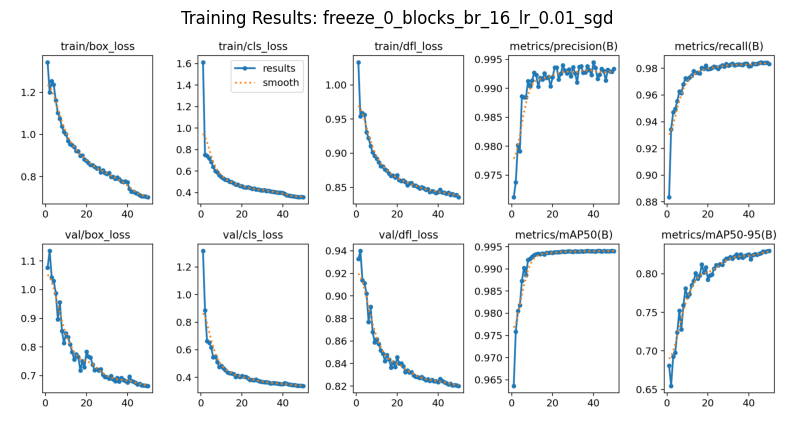

Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 2207.8180.4 MB/s, size: 1424.3 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


                   all        200      11906      0.994      0.983      0.994      0.831
Speed: 0.6ms preprocess, 5.1ms inference, 0.0ms loss, 9.4ms postprocess per image
Results saved to yolo_val_metrics\freeze_0_blocks_br_16_lr_0.01_sgd
Results saved to yolo_val_predictions\freeze_0_blocks_br_16_lr_0.01_sgd
200 labels saved to yolo_val_predictions\freeze_0_blocks_br_16_lr_0.01_sgd\labels
[freeze_0_blocks_br_16_lr_0.01_sgd - Validation] EMA: 41.50%, MSE: 4.21

Model Evaluation Summary:


,Model,Precision,Recall,mAP@50,EMA (%),MSE
0,freeze_0_blocks_br_8_lr_0.001_adam,0.993,0.986,0.994,47.0,4.18
1,freeze_0_blocks_br_16_lr_0.0005_adam,0.993,0.986,0.994,47.0,4.18
2,freeze_0_blocks_br_16_lr_0.001_sgd,0.993,0.973,0.993,32.5,20.45
3,freeze_0_blocks_br_16_lr_0.01_sgd,0.994,0.983,0.994,41.5,4.21


In [5]:
results_learning_hyperparameters = []

for name in ["freeze_0_blocks_br_8_lr_0.001_adam", "freeze_0_blocks_br_16_lr_0.0005_adam",
             "freeze_0_blocks_br_16_lr_0.001_sgd", "freeze_0_blocks_br_16_lr_0.01_sgd"]:

    show_loss_plots(name)

    model_metrics = evaluate_model(name, split='val')
    predict_model(name, split='val')
    val_counts = evaluate_detection_counts(name, split='val')

    precision = model_metrics.box.p
    recall = model_metrics.box.r
    map50 = model_metrics.box.map50
    ema = val_counts['exact_match_accuracy']
    mse = val_counts['mse']


    print(f"[{name} - Validation] EMA: {ema:.2f}%, MSE: {mse:.2f}")

    results_learning_hyperparameters.append({
        'Model': name,
        'Precision': round(precision[0], 3),
        'Recall': round(recall[0], 3),
        'mAP@50': round(map50, 3),
        'EMA (%)': round(ema, 2),
        'MSE': round(mse, 2)
    })

df_learning_hyperparameters = pd.DataFrame(results_learning_hyperparameters)

print("\nModel Evaluation Summary:")
df_learning_hyperparameters

### YOLO Hyperparameter Search for the Best Frozen Model

#### Train the Best Frozen Model with Different Confidence 

In this section, we trained our best model until this point (freeze_0_blocks_br_16_lr_0.001_adam, default conf=0.25, iou=0.7) with different YOLO hyperparameters. To correctly isolate the changes this hyperparameters do, it is decided to first change confidence in the best model, then change the IoU by selecting the one that gives better metrics for different confidence values. Confidence values of 0.1 and 0.5 are tried in this section, the default is 0.25 in YOLO, thus the best model has currently confidence of 0.25.

In [5]:
# Batch size 16 with LR 0.001 and Adam optimizer (conf=0.1 and iou=0.7)

model = train_model_with_yolo_hyperparameters(
    epochs=50,
    optimizer='Adam',
    lr=0.001,
    batch=16,
    name='freeze_0_blocks_br_16_lr_0.001_adam_conf_0.1',
    freeze=0,
    conf=0.1,
    iou=0.7
)

New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=0.1, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=freeze_0_blocks_br_16_lr_0.001_adam_

train: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\train\labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.40.2 ms, read: 159.843.1 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.1\labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.03G      1.322      1.423     0.9763       1118        640: 100%|██████████| 63/63 [00:30<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

                   all        200      11906       0.94      0.864      0.921      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.73G      1.077     0.7048     0.9058        787        640: 100%|██████████| 63/63 [00:15<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        200      11906      0.967      0.933      0.977      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.69G      1.023     0.6317     0.8884        870        640: 100%|██████████| 63/63 [00:14<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        200      11906      0.984      0.949      0.985      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.12G     0.9798     0.5928     0.8812        669        640: 100%|██████████| 63/63 [00:13<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        200      11906      0.988      0.956      0.987      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.48G     0.9432     0.5584      0.868        908        640: 100%|██████████| 63/63 [00:13<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        200      11906       0.99      0.965      0.989      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.97G     0.9213     0.5368      0.867        585        640: 100%|██████████| 63/63 [00:41<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200      11906      0.991      0.968      0.989      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.79G     0.9017     0.5117     0.8602        922        640: 100%|██████████| 63/63 [00:13<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        200      11906      0.988      0.973      0.992      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.39G     0.8948     0.5061      0.859        766        640: 100%|██████████| 63/63 [00:12<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        200      11906      0.988      0.972      0.989      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.92G     0.8795     0.4912     0.8565        900        640: 100%|██████████| 63/63 [00:15<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200      11906      0.991      0.975      0.991      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.05G     0.8656     0.4806     0.8538       1024        640: 100%|██████████| 63/63 [00:19<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        200      11906      0.989      0.976      0.992      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.79G     0.8529     0.4689     0.8513        902        640: 100%|██████████| 63/63 [00:14<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        200      11906      0.991      0.977      0.993      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.91G     0.8439     0.4619     0.8495        736        640: 100%|██████████| 63/63 [00:13<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200      11906      0.991      0.978      0.992      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.55G     0.8571     0.4615     0.8514       1119        640: 100%|██████████| 63/63 [00:12<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        200      11906      0.991      0.977      0.994      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.67G     0.8363     0.4498     0.8451        931        640: 100%|██████████| 63/63 [00:36<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]

                   all        200      11906      0.991      0.978      0.993      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.36G     0.8368     0.4496     0.8469        983        640: 100%|██████████| 63/63 [00:13<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        200      11906      0.993      0.978      0.994      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.12G      0.843      0.448     0.8462       1080        640: 100%|██████████| 63/63 [00:12<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        200      11906      0.992      0.979      0.992      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.81G     0.8274     0.4394     0.8436        827        640: 100%|██████████| 63/63 [00:17<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        200      11906      0.992      0.981      0.994      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.79G      0.828     0.4349     0.8442        843        640: 100%|██████████| 63/63 [00:13<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200      11906      0.992      0.981      0.994      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.18G     0.8327     0.4346     0.8443        718        640: 100%|██████████| 63/63 [00:12<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        200      11906      0.992      0.981      0.994      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       5.5G     0.8095     0.4281     0.8439        772        640: 100%|██████████| 63/63 [00:12<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        200      11906      0.992      0.982      0.994      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.69G     0.8025     0.4182     0.8401        949        640: 100%|██████████| 63/63 [00:13<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200      11906      0.993      0.983      0.994      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       4.1G     0.7996     0.4165     0.8394       1063        640: 100%|██████████| 63/63 [00:12<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        200      11906      0.993      0.984      0.994      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.47G     0.8025     0.4162     0.8408       1217        640: 100%|██████████| 63/63 [00:12<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        200      11906      0.992      0.984      0.994      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.27G     0.7936     0.4119      0.839        502        640: 100%|██████████| 63/63 [00:15<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200      11906      0.994      0.982      0.994      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.38G      0.786     0.4064     0.8357        857        640: 100%|██████████| 63/63 [00:21<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        200      11906      0.993      0.983      0.994      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       5.9G     0.8038     0.4119     0.8396        986        640: 100%|██████████| 63/63 [00:14<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200      11906      0.993      0.983      0.994      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.92G     0.7814     0.4018      0.839        908        640: 100%|██████████| 63/63 [00:13<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        200      11906      0.993      0.983      0.994      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.35G      0.784     0.4028     0.8367        914        640: 100%|██████████| 63/63 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        200      11906      0.993      0.984      0.994      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.53G     0.7815     0.3972     0.8368        730        640: 100%|██████████| 63/63 [00:12<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200      11906      0.993      0.985      0.994      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.07G     0.7783     0.3956     0.8353        709        640: 100%|██████████| 63/63 [00:12<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        200      11906      0.994      0.983      0.994      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.94G       0.78     0.3976     0.8339       1028        640: 100%|██████████| 63/63 [00:50<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]

                   all        200      11906      0.993      0.985      0.994      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.28G     0.7676     0.3893     0.8355        797        640: 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200      11906      0.992      0.984      0.994      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.87G      0.769     0.3896     0.8343        935        640: 100%|██████████| 63/63 [00:12<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200      11906      0.993      0.984      0.994      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.27G     0.7605     0.3859     0.8327       1109        640: 100%|██████████| 63/63 [00:12<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        200      11906      0.994      0.985      0.994      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.47G     0.7701      0.387     0.8337        949        640: 100%|██████████| 63/63 [00:23<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        200      11906      0.992      0.985      0.994      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.27G     0.7623     0.3827     0.8302        800        640: 100%|██████████| 63/63 [00:13<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        200      11906      0.992      0.986      0.994      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.36G     0.7546      0.381     0.8326        895        640: 100%|██████████| 63/63 [00:23<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200      11906      0.993      0.984      0.994      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.47G     0.7506     0.3789     0.8312        863        640: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200      11906      0.992      0.987      0.994      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.75G     0.7575     0.3779     0.8299       1134        640: 100%|██████████| 63/63 [00:12<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200      11906      0.993      0.986      0.994      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       5.9G     0.7534     0.3782     0.8309        719        640: 100%|██████████| 63/63 [00:15<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        200      11906      0.993      0.986      0.994      0.848


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.71G     0.7319     0.3786     0.8312        667        640: 100%|██████████| 63/63 [00:12<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200      11906      0.994      0.983      0.994      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.95G     0.7194     0.3669     0.8282        629        640: 100%|██████████| 63/63 [00:11<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        200      11906      0.993      0.984      0.994      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.34G     0.7196     0.3612     0.8281        500        640: 100%|██████████| 63/63 [00:11<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200      11906      0.993      0.985      0.994      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       4.1G     0.7134     0.3564     0.8271        441        640: 100%|██████████| 63/63 [00:11<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200      11906      0.993      0.984      0.994      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.33G     0.7118     0.3537     0.8283        447        640: 100%|██████████| 63/63 [00:11<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        200      11906      0.994      0.984      0.994       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.33G      0.701     0.3495     0.8256        444        640: 100%|██████████| 63/63 [00:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

                   all        200      11906      0.993      0.986      0.994      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.92G     0.6938     0.3451      0.826        431        640: 100%|██████████| 63/63 [00:11<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200      11906      0.993      0.986      0.994      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.47G     0.6934     0.3444     0.8247        712        640: 100%|██████████| 63/63 [00:11<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200      11906      0.994      0.985      0.994      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.11G     0.6913     0.3434     0.8247        601        640: 100%|██████████| 63/63 [00:11<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200      11906      0.993      0.986      0.994      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.18G     0.6892     0.3403     0.8224        611        640: 100%|██████████| 63/63 [00:11<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        200      11906      0.993      0.986      0.994      0.853



50 epochs completed in 0.267 hours.
Optimizer stripped from yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.1\weights\last.pt, 6.2MB
Optimizer stripped from yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.1\weights\best.pt, 6.2MB

Validating yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.1\weights\best.pt...
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


                   all        200      11906      0.993      0.986      0.994      0.853
Speed: 0.4ms preprocess, 2.6ms inference, 0.0ms loss, 9.6ms postprocess per image
Results saved to yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.1
Training completed for model: freeze_0_blocks_br_16_lr_0.001_adam_conf_0.1


In [6]:
# Batch size 16 with LR 0.001 and Adam optimizer (conf=0.5 and iou=0.7)

model = train_model_with_yolo_hyperparameters(
    epochs=50,
    optimizer='Adam',
    lr=0.001,
    batch=16,
    name='freeze_0_blocks_br_16_lr_0.001_adam_conf_0.5',
    freeze=0,
    conf=0.5,
    iou=0.7
)

New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=0.5, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=freeze_0_blocks_br_16_lr_0.001_adam_

train: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\train\labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 654.3624.2 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.12\labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.12
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.09G      1.322      1.423     0.9763       1118        640: 100%|██████████| 63/63 [00:30<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]

                   all        200      11906      0.997     0.0316      0.514       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       5.8G      1.077     0.7048     0.9058        787        640: 100%|██████████| 63/63 [00:14<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        200      11906      0.964      0.936      0.965      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.75G      1.023     0.6317     0.8884        870        640: 100%|██████████| 63/63 [00:13<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        200      11906      0.984      0.949      0.976      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.18G     0.9798     0.5928     0.8812        669        640: 100%|██████████| 63/63 [00:13<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        200      11906      0.997      0.937      0.967      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.54G     0.9432     0.5584      0.868        908        640: 100%|██████████| 63/63 [00:13<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        200      11906      0.993      0.962       0.98      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.03G     0.9213     0.5368      0.867        585        640: 100%|██████████| 63/63 [00:42<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200      11906      0.995      0.961      0.979      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.84G     0.9017     0.5117     0.8602        922        640: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        200      11906      0.991      0.971      0.984      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.45G     0.8948     0.5061      0.859        766        640: 100%|██████████| 63/63 [00:13<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200      11906      0.995      0.953      0.976      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.98G     0.8795     0.4912     0.8565        900        640: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200      11906      0.996      0.966      0.982      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.11G     0.8656     0.4806     0.8538       1024        640: 100%|██████████| 63/63 [00:19<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        200      11906      0.991      0.974      0.986      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.85G     0.8529     0.4689     0.8513        902        640: 100%|██████████| 63/63 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        200      11906      0.991      0.977      0.987      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.97G     0.8439     0.4619     0.8495        736        640: 100%|██████████| 63/63 [00:14<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        200      11906      0.996      0.971      0.985      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.61G     0.8571     0.4615     0.8514       1119        640: 100%|██████████| 63/63 [00:13<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200      11906       0.99      0.978      0.989      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.73G     0.8363     0.4498     0.8451        931        640: 100%|██████████| 63/63 [00:36<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

                   all        200      11906      0.993      0.975      0.987      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.42G     0.8368     0.4496     0.8469        983        640: 100%|██████████| 63/63 [00:13<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200      11906      0.994      0.977      0.988      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.17G      0.843      0.448     0.8462       1080        640: 100%|██████████| 63/63 [00:12<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200      11906      0.995      0.975      0.986      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.87G     0.8274     0.4394     0.8436        827        640: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        200      11906      0.995      0.978      0.988      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.85G      0.828     0.4349     0.8442        843        640: 100%|██████████| 63/63 [00:13<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        200      11906      0.995      0.975      0.986       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.24G     0.8327     0.4346     0.8443        718        640: 100%|██████████| 63/63 [00:13<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        200      11906      0.995      0.977      0.987      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.56G     0.8095     0.4281     0.8439        772        640: 100%|██████████| 63/63 [00:13<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        200      11906      0.996      0.976      0.987      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.75G     0.8025     0.4182     0.8401        949        640: 100%|██████████| 63/63 [00:13<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        200      11906      0.993      0.983       0.99      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.16G     0.7996     0.4165     0.8394       1063        640: 100%|██████████| 63/63 [00:13<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        200      11906      0.994      0.982       0.99      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.53G     0.8025     0.4162     0.8408       1217        640: 100%|██████████| 63/63 [00:13<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200      11906      0.994      0.979      0.989      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.32G     0.7936     0.4119      0.839        502        640: 100%|██████████| 63/63 [00:15<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        200      11906      0.994      0.981       0.99      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.44G      0.786     0.4064     0.8357        857        640: 100%|██████████| 63/63 [00:22<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        200      11906      0.995       0.98      0.989       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.96G     0.8038     0.4119     0.8396        986        640: 100%|██████████| 63/63 [00:14<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        200      11906      0.994      0.982       0.99      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.98G     0.7814     0.4018      0.839        908        640: 100%|██████████| 63/63 [00:14<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        200      11906      0.995      0.982       0.99      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       6.4G      0.784     0.4028     0.8367        914        640: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        200      11906      0.994      0.981       0.99      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.59G     0.7815     0.3972     0.8368        730        640: 100%|██████████| 63/63 [00:12<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        200      11906      0.995      0.982       0.99      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.13G     0.7783     0.3956     0.8353        709        640: 100%|██████████| 63/63 [00:12<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        200      11906      0.995      0.982       0.99      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         7G       0.78     0.3976     0.8339       1028        640: 100%|██████████| 63/63 [00:47<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

                   all        200      11906      0.994      0.984       0.99       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.34G     0.7676     0.3893     0.8355        797        640: 100%|██████████| 63/63 [00:12<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200      11906      0.993      0.984       0.99      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.93G      0.769     0.3896     0.8343        935        640: 100%|██████████| 63/63 [00:12<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        200      11906      0.993      0.984       0.99      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.33G     0.7605     0.3859     0.8327       1109        640: 100%|██████████| 63/63 [00:12<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200      11906      0.995      0.983       0.99      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.54G     0.7701      0.387     0.8337        949        640: 100%|██████████| 63/63 [00:25<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200      11906      0.993      0.984       0.99      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.33G     0.7623     0.3827     0.8302        800        640: 100%|██████████| 63/63 [00:12<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        200      11906      0.994      0.983       0.99      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.41G     0.7546      0.381     0.8326        895        640: 100%|██████████| 63/63 [00:59<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

                   all        200      11906      0.993      0.984      0.991      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.53G     0.7506     0.3789     0.8312        863        640: 100%|██████████| 63/63 [00:16<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        200      11906      0.994      0.985      0.991      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.81G     0.7575     0.3779     0.8299       1134        640: 100%|██████████| 63/63 [00:13<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        200      11906      0.995      0.982       0.99      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.96G     0.7534     0.3782     0.8309        719        640: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        200      11906      0.993      0.986      0.991      0.847


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.77G     0.7319     0.3786     0.8312        667        640: 100%|██████████| 63/63 [00:12<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        200      11906      0.995      0.982       0.99      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.01G     0.7194     0.3669     0.8282        629        640: 100%|██████████| 63/63 [00:11<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200      11906      0.994      0.983       0.99      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       4.4G     0.7196     0.3612     0.8281        500        640: 100%|██████████| 63/63 [00:11<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        200      11906      0.994      0.984      0.991      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.15G     0.7134     0.3564     0.8271        441        640: 100%|██████████| 63/63 [00:11<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200      11906      0.995      0.982       0.99      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.39G     0.7118     0.3537     0.8283        447        640: 100%|██████████| 63/63 [00:11<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        200      11906      0.995      0.984      0.991      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.39G      0.701     0.3495     0.8256        444        640: 100%|██████████| 63/63 [00:11<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]

                   all        200      11906      0.995      0.984      0.991      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.98G     0.6938     0.3451      0.826        431        640: 100%|██████████| 63/63 [00:11<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        200      11906      0.994      0.985      0.991      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.53G     0.6934     0.3444     0.8247        712        640: 100%|██████████| 63/63 [00:11<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        200      11906      0.994      0.985      0.991       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.17G     0.6913     0.3434     0.8247        601        640: 100%|██████████| 63/63 [00:11<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        200      11906      0.994      0.985      0.991       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.24G     0.6892     0.3403     0.8224        611        640: 100%|██████████| 63/63 [00:11<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        200      11906      0.995      0.984      0.991      0.851



50 epochs completed in 0.282 hours.
Optimizer stripped from yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.12\weights\last.pt, 6.2MB
Optimizer stripped from yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.12\weights\best.pt, 6.2MB

Validating yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.12\weights\best.pt...
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


                   all        200      11906      0.995      0.984      0.991      0.851
Speed: 0.4ms preprocess, 2.4ms inference, 0.0ms loss, 10.6ms postprocess per image
Results saved to yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.12
Training completed for model: freeze_0_blocks_br_16_lr_0.001_adam_conf_0.1


#### Evaluate the Best Frozen Model with Different Confidence 

In this section, the models trained in the previous section is evaluated using validation dataset using metrics Precision, Recall, mAP@50, Exact Match Accuracy (EMA), and Mean Squared Error (MSE).

We evaluated the best model which had default confidence 0.25 with two different confidence values 0.1 and 0.5 respectively. All models got very similar and good Precision, Recall, and mAP@50 scores, which suggests that object detection capabilities are consistent in terms of identifying and localizing cars correctly. However, meaningful changes were observed in the ESA and MSE metrics, which was the be expected since they are metrics directly controlled by confidence threshold.

The model that is trained with 0.1 confidence threshold resulted in the worse ESA and MSE metrics among the three of them, %33.5 and 13.88 respectively. This indicates that the model tends to over-predict, introducing many false positives due to accepting detections with very low confidence scores.

The model that is trained with 0.5 confidence threshold resulted in better ESA performance (%45) over 0.1 confidence but worse than 0.25 confidence which is our base model (%47 ESA). It also had the best MSE of 2.69 among all the models. The drop in ESA compared to out best model is the result of higher confidence discarding some of the correct but lower scored car predictions. However, when we look at MSE, it most likely missed the exact match number of the ground truth images with lower numbers compared to our best model.

Our best model, trained with 0.25 confidence in the previous section, offered the best overall tradeoff. It achieves the highest EMA at 47.0% and maintains a low MSE of 3.66.



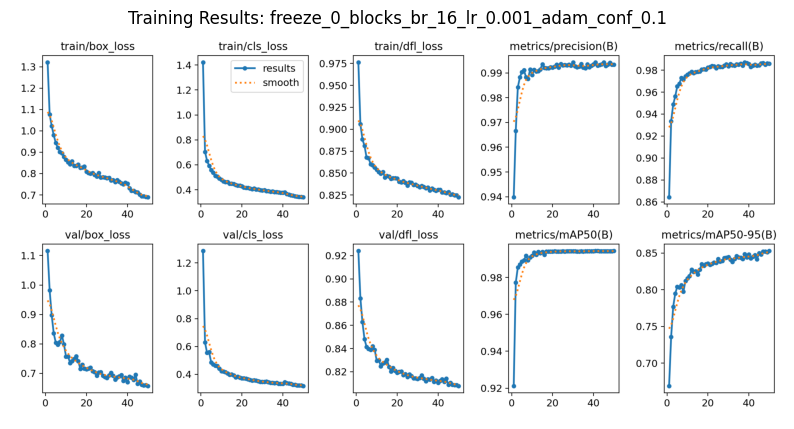

Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 890.862.0 MB/s, size: 1366.2 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


                   all        200      11906      0.993      0.986      0.994      0.853
Speed: 0.6ms preprocess, 4.3ms inference, 0.0ms loss, 10.2ms postprocess per image
Results saved to yolo_val_metrics\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.1
Results saved to yolo_val_predictions\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.1
200 labels saved to yolo_val_predictions\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.1\labels
[freeze_0_blocks_br_16_lr_0.001_adam_conf_0.1 - Validation] EMA: 33.50%, MSE: 13.88


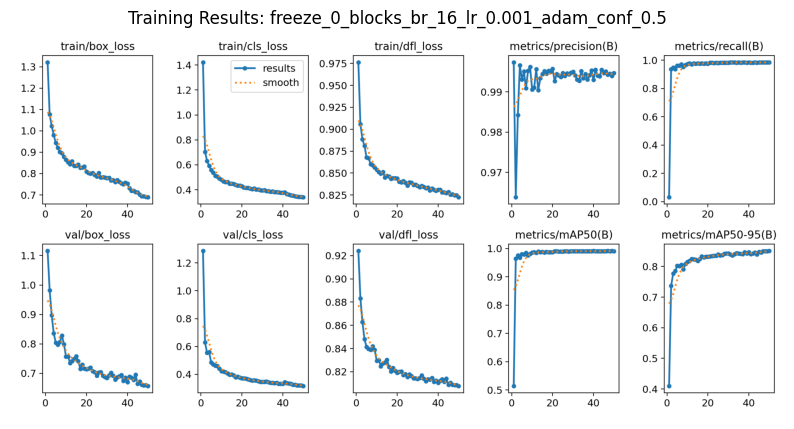

Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1691.2413.9 MB/s, size: 1450.8 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


                   all        200      11906      0.995      0.984      0.991      0.851
Speed: 0.4ms preprocess, 4.5ms inference, 0.0ms loss, 9.4ms postprocess per image
Results saved to yolo_val_metrics\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.5
Results saved to yolo_val_predictions\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.5
200 labels saved to yolo_val_predictions\freeze_0_blocks_br_16_lr_0.001_adam_conf_0.5\labels
[freeze_0_blocks_br_16_lr_0.001_adam_conf_0.5 - Validation] EMA: 45.00%, MSE: 2.69

Model Evaluation Summary:


,Model,Precision,Recall,mAP@50,EMA (%),MSE
0,freeze_0_blocks_br_16_lr_0.001_adam_conf_0.1,0.993,0.986,0.994,33.5,13.88
1,freeze_0_blocks_br_16_lr_0.001_adam_conf_0.5,0.995,0.984,0.991,45.0,2.69


In [17]:
results_confidence = []

for name, conf in zip(["freeze_0_blocks_br_16_lr_0.001_adam_conf_0.1", "freeze_0_blocks_br_16_lr_0.001_adam_conf_0.5"], [0.1, 0.5]):

    show_loss_plots(name)

    model_metrics = evaluate_model_with_yolo_hyperparameters(name, split='val', conf=conf)
    predict_model_with_yolo_hyperparameters(name, split='val', conf=conf)
    val_counts = evaluate_detection_counts(name, split='val')

    precision = model_metrics.box.p
    recall = model_metrics.box.r
    map50 = model_metrics.box.map50
    ema = val_counts['exact_match_accuracy']
    mse = val_counts['mse']


    print(f"[{name} - Validation] EMA: {ema:.2f}%, MSE: {mse:.2f}")

    results_confidence.append({
        'Model': name,
        'Precision': round(precision[0], 3),
        'Recall': round(recall[0], 3),
        'mAP@50': round(map50, 3),
        'EMA (%)': round(ema, 2),
        'MSE': round(mse, 2)
    })

df_confidence = pd.DataFrame(results_confidence)

print("\nModel Evaluation Summary:")
df_confidence

#### Train the Best Frozen Model with Different IoU

Our best model (freeze_0_blocks_br_16_lr_0.001_adam, default conf=0.25, iou=0.7) remained the same from the previous section. In this section, we trained it with two different IoU thresholds, 0.5 and 0.8 respectively.

In [8]:
# Batch size 16 with LR 0.001 and Adam optimizer (conf=0.25 and iou=0.5)

model = train_model_with_yolo_hyperparameters(
    epochs=50,
    optimizer='Adam',
    lr=0.001,
    batch=16,
    name='freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5',
    freeze=0,
    conf=0.25,
    iou=0.5
)

New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=0.25, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.5, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=freeze_0_blocks_br_16_lr_0.001_adam

train: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\train\labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 614.3180.7 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5\labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.13G      1.322      1.423     0.9763       1118        640: 100%|██████████| 63/63 [00:31<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200      11906      0.997      0.502      0.749      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.81G      1.077     0.7048     0.9058        787        640: 100%|██████████| 63/63 [00:14<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        200      11906      0.975      0.943      0.976      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.75G      1.023     0.6317     0.8884        870        640: 100%|██████████| 63/63 [00:13<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        200      11906      0.986      0.959      0.983       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.17G     0.9798     0.5928     0.8812        669        640: 100%|██████████| 63/63 [00:12<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        200      11906      0.985      0.968      0.982      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       5.8G     0.9432     0.5584      0.868        908        640: 100%|██████████| 63/63 [00:15<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        200      11906      0.991      0.972      0.986      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.02G     0.9213     0.5368      0.867        585        640: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200      11906      0.993      0.969      0.986      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.86G     0.9017     0.5117     0.8602        922        640: 100%|██████████| 63/63 [00:13<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200      11906      0.988      0.977       0.99      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.43G     0.8948     0.5061      0.859        766        640: 100%|██████████| 63/63 [00:12<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200      11906      0.992      0.973      0.985      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.97G     0.8795     0.4912     0.8565        900        640: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        200      11906      0.991       0.98      0.989      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.11G     0.8656     0.4806     0.8538       1024        640: 100%|██████████| 63/63 [00:18<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        200      11906       0.99      0.978       0.99      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.84G     0.8529     0.4689     0.8513        902        640: 100%|██████████| 63/63 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        200      11906      0.991       0.98      0.991       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.96G     0.8439     0.4619     0.8495        736        640: 100%|██████████| 63/63 [00:14<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        200      11906      0.992       0.98       0.99      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       4.6G     0.8571     0.4615     0.8514       1119        640: 100%|██████████| 63/63 [00:12<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200      11906       0.99      0.983      0.992      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.72G     0.8363     0.4498     0.8451        931        640: 100%|██████████| 63/63 [00:36<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]

                   all        200      11906      0.992       0.98       0.99      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.68G     0.8368     0.4496     0.8469        983        640: 100%|██████████| 63/63 [00:13<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        200      11906      0.992      0.983      0.992       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.16G      0.843      0.448     0.8462       1080        640: 100%|██████████| 63/63 [00:12<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        200      11906      0.991      0.983       0.99      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.92G     0.8274     0.4394     0.8436        827        640: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        200      11906      0.992      0.984      0.991      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.84G      0.828     0.4349     0.8442        843        640: 100%|██████████| 63/63 [00:13<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        200      11906      0.991      0.984      0.991      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.23G     0.8327     0.4346     0.8443        718        640: 100%|██████████| 63/63 [00:12<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200      11906      0.991      0.985      0.991      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.54G     0.8095     0.4281     0.8439        772        640: 100%|██████████| 63/63 [00:12<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200      11906      0.992      0.985      0.991      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.74G     0.8025     0.4182     0.8401        949        640: 100%|██████████| 63/63 [00:13<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        200      11906      0.994      0.984      0.993      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.15G     0.7996     0.4165     0.8394       1063        640: 100%|██████████| 63/63 [00:12<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        200      11906      0.994      0.984      0.993      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.51G     0.8025     0.4162     0.8408       1217        640: 100%|██████████| 63/63 [00:12<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        200      11906       0.99      0.987      0.992      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.31G     0.7936     0.4119      0.839        502        640: 100%|██████████| 63/63 [00:15<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        200      11906      0.991      0.986      0.993      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.55G      0.786     0.4064     0.8357        857        640: 100%|██████████| 63/63 [00:27<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200      11906      0.994      0.984      0.992      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.96G     0.8038     0.4119     0.8396        986        640: 100%|██████████| 63/63 [00:14<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200      11906      0.993      0.984      0.992      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.97G     0.7814     0.4018      0.839        908        640: 100%|██████████| 63/63 [00:14<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        200      11906      0.993      0.985      0.993      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.39G      0.784     0.4028     0.8367        914        640: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        200      11906      0.993      0.985      0.993      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.58G     0.7815     0.3972     0.8368        730        640: 100%|██████████| 63/63 [00:13<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        200      11906      0.993      0.986      0.993      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.12G     0.7783     0.3956     0.8353        709        640: 100%|██████████| 63/63 [00:12<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        200      11906      0.995      0.984      0.993      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.98G       0.78     0.3976     0.8339       1028        640: 100%|██████████| 63/63 [00:21<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        200      11906      0.994      0.986      0.994      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.33G     0.7676     0.3893     0.8355        797        640: 100%|██████████| 63/63 [00:12<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        200      11906      0.993      0.985      0.994      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.91G      0.769     0.3896     0.8343        935        640: 100%|██████████| 63/63 [00:12<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200      11906      0.992      0.985      0.994      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.62G     0.7605     0.3859     0.8327       1109        640: 100%|██████████| 63/63 [00:13<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200      11906      0.992      0.988      0.994      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.52G     0.7701      0.387     0.8337        949        640: 100%|██████████| 63/63 [00:27<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        200      11906      0.993      0.985      0.994      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.32G     0.7623     0.3827     0.8302        800        640: 100%|██████████| 63/63 [00:12<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200      11906      0.993      0.986      0.993      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       8.4G     0.7546      0.381     0.8326        895        640: 100%|██████████| 63/63 [01:01<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

                   all        200      11906      0.991      0.988      0.994      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.52G     0.7506     0.3789     0.8312        863        640: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]

                   all        200      11906      0.992       0.99      0.994      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       4.8G     0.7575     0.3779     0.8299       1134        640: 100%|██████████| 63/63 [00:12<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        200      11906      0.993      0.987      0.993      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.95G     0.7534     0.3782     0.8309        719        640: 100%|██████████| 63/63 [00:16<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200      11906      0.994      0.986      0.994      0.848


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.76G     0.7319     0.3786     0.8312        667        640: 100%|██████████| 63/63 [00:12<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        200      11906       0.99      0.988      0.993      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.01G     0.7194     0.3669     0.8282        629        640: 100%|██████████| 63/63 [00:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        200      11906       0.99      0.989      0.994      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.39G     0.7196     0.3612     0.8281        500        640: 100%|██████████| 63/63 [00:11<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        200      11906      0.993      0.986      0.994      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.14G     0.7134     0.3564     0.8271        441        640: 100%|██████████| 63/63 [00:11<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200      11906      0.991      0.988      0.993      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.38G     0.7118     0.3537     0.8283        447        640: 100%|██████████| 63/63 [00:11<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        200      11906      0.992      0.988      0.994       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.38G      0.701     0.3495     0.8256        444        640: 100%|██████████| 63/63 [00:11<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

                   all        200      11906      0.994      0.987      0.994      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.97G     0.6938     0.3451      0.826        431        640: 100%|██████████| 63/63 [00:11<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200      11906      0.994      0.987      0.994      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.51G     0.6934     0.3444     0.8247        712        640: 100%|██████████| 63/63 [00:11<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]

                   all        200      11906      0.994      0.986      0.994      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.16G     0.6913     0.3434     0.8247        601        640: 100%|██████████| 63/63 [00:11<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        200      11906      0.994      0.987      0.994      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.23G     0.6892     0.3403     0.8224        611        640: 100%|██████████| 63/63 [00:11<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200      11906      0.994      0.986      0.994      0.852



50 epochs completed in 0.275 hours.
Optimizer stripped from yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5\weights\last.pt, 6.2MB
Optimizer stripped from yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5\weights\best.pt, 6.2MB

Validating yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5\weights\best.pt...
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


                   all        200      11906      0.992      0.989      0.994      0.852
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5
Training completed for model: freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5


In [9]:
# Batch size 16 with LR 0.001 and Adam optimizer (conf=0.25 and iou=0.8)

model = train_model_with_yolo_hyperparameters(
    epochs=50,
    optimizer='Adam',
    lr=0.001,
    batch=16,
    name='freeze_0_blocks_br_16_lr_0.001_adam_iou_0.8',
    freeze=0,
    conf=0.25,
    iou=0.8
)

New https://pypi.org/project/ultralytics/8.3.143 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=0.25, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_cars_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.8, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=freeze_0_blocks_br_16_lr_0.001_adam

train: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\train\labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 1007.1229.3 MB/s, size: 1312.4 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.8\labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.8
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       7.1G      1.322      1.423     0.9763       1118        640: 100%|██████████| 63/63 [00:31<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200      11906      0.992      0.502      0.748      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.79G      1.077     0.7048     0.9058        787        640: 100%|██████████| 63/63 [00:14<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200      11906      0.959      0.922      0.971      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.73G      1.023     0.6317     0.8884        870        640: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200      11906       0.98      0.946      0.981      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.18G     0.9798     0.5928     0.8812        669        640: 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200      11906      0.984      0.951      0.981      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.54G     0.9432     0.5584      0.868        908        640: 100%|██████████| 63/63 [00:13<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200      11906      0.987      0.962      0.985      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.02G     0.9213     0.5368      0.867        585        640: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200      11906      0.987      0.964      0.985      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.84G     0.9017     0.5117     0.8602        922        640: 100%|██████████| 63/63 [00:12<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200      11906      0.986      0.969      0.989      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.44G     0.8948     0.5061      0.859        766        640: 100%|██████████| 63/63 [00:12<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200      11906      0.987      0.963      0.985      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.98G     0.8795     0.4912     0.8565        900        640: 100%|██████████| 63/63 [00:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200      11906       0.99       0.97      0.989      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.11G     0.8656     0.4806     0.8538       1024        640: 100%|██████████| 63/63 [00:18<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200      11906       0.99       0.97       0.99      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.85G     0.8529     0.4689     0.8513        902        640: 100%|██████████| 63/63 [00:14<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        200      11906      0.989      0.973      0.991      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.97G     0.8439     0.4619     0.8495        736        640: 100%|██████████| 63/63 [00:14<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        200      11906       0.99      0.974      0.989      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.61G     0.8571     0.4615     0.8514       1119        640: 100%|██████████| 63/63 [00:12<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        200      11906      0.989      0.975      0.992      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.76G     0.8363     0.4498     0.8451        931        640: 100%|██████████| 63/63 [00:34<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        200      11906      0.989      0.975       0.99      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.42G     0.8368     0.4496     0.8469        983        640: 100%|██████████| 63/63 [00:12<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200      11906      0.991      0.976      0.991       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.17G      0.843      0.448     0.8462       1080        640: 100%|██████████| 63/63 [00:12<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200      11906      0.991      0.977       0.99      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.87G     0.8274     0.4394     0.8436        827        640: 100%|██████████| 63/63 [00:17<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        200      11906      0.993      0.977      0.991      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.85G      0.828     0.4349     0.8442        843        640: 100%|██████████| 63/63 [00:14<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        200      11906       0.99      0.977      0.991      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.24G     0.8327     0.4346     0.8443        718        640: 100%|██████████| 63/63 [00:12<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200      11906      0.991      0.979      0.991      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.55G     0.8095     0.4281     0.8439        772        640: 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200      11906      0.992      0.977      0.991      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.75G     0.8025     0.4182     0.8401        949        640: 100%|██████████| 63/63 [00:13<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        200      11906      0.991       0.98      0.993      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.16G     0.7996     0.4165     0.8394       1063        640: 100%|██████████| 63/63 [00:12<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200      11906      0.991      0.982      0.993      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.53G     0.8025     0.4162     0.8408       1217        640: 100%|██████████| 63/63 [00:12<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200      11906      0.988      0.981      0.992      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.32G     0.7936     0.4119      0.839        502        640: 100%|██████████| 63/63 [00:15<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        200      11906      0.993      0.979      0.993      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.44G      0.786     0.4064     0.8357        857        640: 100%|██████████| 63/63 [00:24<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200      11906      0.991       0.98      0.992      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.96G     0.8038     0.4119     0.8396        986        640: 100%|██████████| 63/63 [00:14<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        200      11906      0.991      0.981      0.992      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.98G     0.7814     0.4018      0.839        908        640: 100%|██████████| 63/63 [00:14<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        200      11906      0.992      0.981      0.993      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       6.4G      0.784     0.4028     0.8367        914        640: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200      11906       0.99      0.982      0.993      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.59G     0.7815     0.3972     0.8368        730        640: 100%|██████████| 63/63 [00:13<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        200      11906      0.991      0.983      0.993      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.12G     0.7783     0.3956     0.8353        709        640: 100%|██████████| 63/63 [00:12<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200      11906      0.991      0.982      0.993      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         7G       0.78     0.3976     0.8339       1028        640: 100%|██████████| 63/63 [00:21<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200      11906      0.992      0.982      0.994      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.34G     0.7676     0.3893     0.8355        797        640: 100%|██████████| 63/63 [00:12<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        200      11906       0.99      0.982      0.994      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.92G      0.769     0.3896     0.8343        935        640: 100%|██████████| 63/63 [00:12<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        200      11906      0.992      0.982      0.994      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.33G     0.7605     0.3859     0.8327       1109        640: 100%|██████████| 63/63 [00:12<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200      11906      0.992      0.983      0.994      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.53G     0.7701      0.387     0.8337        949        640: 100%|██████████| 63/63 [00:26<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200      11906      0.991      0.982      0.994      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.33G     0.7623     0.3827     0.8302        800        640: 100%|██████████| 63/63 [00:12<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        200      11906      0.991      0.981      0.993      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.41G     0.7546      0.381     0.8326        895        640: 100%|██████████| 63/63 [00:57<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]

                   all        200      11906      0.991      0.983      0.994      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.52G     0.7506     0.3789     0.8312        863        640: 100%|██████████| 63/63 [00:17<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200      11906       0.99      0.985      0.994      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.81G     0.7575     0.3779     0.8299       1134        640: 100%|██████████| 63/63 [00:12<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200      11906       0.99      0.984      0.993      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.96G     0.7534     0.3782     0.8309        719        640: 100%|██████████| 63/63 [00:16<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        200      11906      0.991      0.984      0.994      0.848


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.77G     0.7319     0.3786     0.8312        667        640: 100%|██████████| 63/63 [00:12<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200      11906      0.994      0.981      0.993      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.01G     0.7194     0.3669     0.8282        629        640: 100%|██████████| 63/63 [00:11<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200      11906      0.991      0.983      0.994      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       4.4G     0.7196     0.3612     0.8281        500        640: 100%|██████████| 63/63 [00:11<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        200      11906      0.991      0.983      0.994      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.15G     0.7134     0.3564     0.8271        441        640: 100%|██████████| 63/63 [00:11<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        200      11906      0.993      0.981      0.993      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.39G     0.7118     0.3537     0.8283        447        640: 100%|██████████| 63/63 [00:11<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        200      11906      0.992      0.983      0.994       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.39G      0.701     0.3495     0.8256        444        640: 100%|██████████| 63/63 [00:11<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        200      11906      0.992      0.983      0.994      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.98G     0.6938     0.3451      0.826        431        640: 100%|██████████| 63/63 [00:11<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        200      11906      0.992      0.985      0.994      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.52G     0.6934     0.3444     0.8247        712        640: 100%|██████████| 63/63 [00:11<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        200      11906      0.993      0.983      0.994      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.17G     0.6913     0.3434     0.8247        601        640: 100%|██████████| 63/63 [00:11<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        200      11906      0.993      0.983      0.994      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.24G     0.6892     0.3403     0.8224        611        640: 100%|██████████| 63/63 [00:11<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        200      11906      0.992      0.983      0.994      0.852



50 epochs completed in 0.270 hours.
Optimizer stripped from yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.8\weights\last.pt, 6.2MB
Optimizer stripped from yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.8\weights\best.pt, 6.2MB

Validating yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.8\weights\best.pt...
Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


                   all        200      11906      0.993      0.983      0.994      0.852
Speed: 0.4ms preprocess, 2.0ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to yolo_models\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.8
Training completed for model: freeze_0_blocks_br_16_lr_0.001_adam_iou_0.8


#### Evaluate the Best Frozen Model with Different IoU

In this section, the models trained in the previous section is evaluated using validation dataset using metrics Precision, Recall, mAP@50, Exact Match Accuracy (EMA), and Mean Squared Error (MSE).

When we look at the evaluation metrics, we can see that all three models, using IoU thresholds of 0.5, 0.7 (best model), and 0.8, gave pretty similar results regarding Precision, Recall, and mAP@50. We can see that varying IoU threshold did not change the model's ability to correctly detect and localize cars.

However, we can observe noticeably changes in the EMA and MSE metrics among all the models. Lowering the IoU threshold to 0.5 results in the highest EMA of 50.5% and the lowest MSE of 2.50. Lowering the IoU threshold allowed the model to suppress overlapping boxes more strict, getting rid of potentially false positive negative boxes and resulting in better EMA and MSE score. This makes sense as the dataset consists of drone images of a parking lot, which could have many cars close to each other, generating more bounding boxes than the ground truth.

On the other hand, increasing the IoU threshold to 0.8 achieved the worst results among them, EMA score of %39 and MSE of 8.76. The reason for that is partially explained in the paragraph above. When we set the IoU threshold higher, we suppressed less bounding boxes, potentially resulting in more bounding boxes, thus predictions compared to the ground truth.

Considering all the metrics and EMA specifically, our best model from this section became the model "freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5", which also had a default confidence of 0.25.

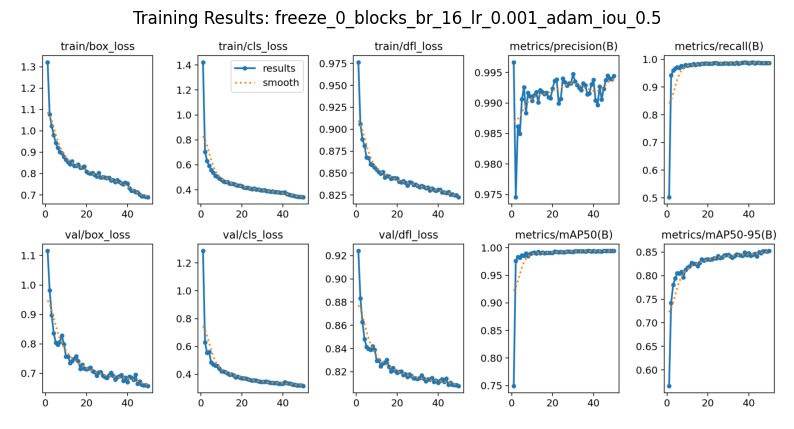

Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1610.5184.1 MB/s, size: 1231.0 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


                   all        200      11906      0.992      0.989      0.994      0.853
Speed: 0.4ms preprocess, 4.5ms inference, 0.0ms loss, 9.6ms postprocess per image
Results saved to yolo_val_metrics\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5
Results saved to yolo_val_predictions\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5
200 labels saved to yolo_val_predictions\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5\labels
[freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5 - Validation] EMA: 50.50%, MSE: 2.50


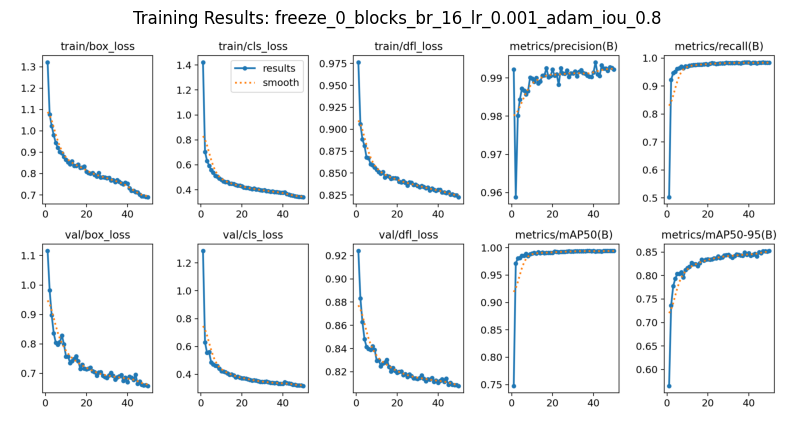

Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 2121.3476.8 MB/s, size: 1292.6 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\val\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


                   all        200      11906      0.993      0.983      0.994      0.853
Speed: 0.5ms preprocess, 4.2ms inference, 0.0ms loss, 8.9ms postprocess per image
Results saved to yolo_val_metrics\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.8
Results saved to yolo_val_predictions\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.8
200 labels saved to yolo_val_predictions\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.8\labels
[freeze_0_blocks_br_16_lr_0.001_adam_iou_0.8 - Validation] EMA: 39.00%, MSE: 8.76

Model Evaluation Summary:


,Model,Precision,Recall,mAP@50,EMA (%),MSE
0,freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5,0.992,0.989,0.994,50.5,2.50
1,freeze_0_blocks_br_16_lr_0.001_adam_iou_0.8,0.993,0.983,0.994,39.0,8.76


In [15]:
results_iou = []

for name, iou in zip(["freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5", "freeze_0_blocks_br_16_lr_0.001_adam_iou_0.8"], [0.5, 0.8]):

    show_loss_plots(name)

    model_metrics = evaluate_model_with_yolo_hyperparameters(name, split='val', iou=iou)
    predict_model_with_yolo_hyperparameters(name, split='val', iou=iou)
    val_counts = evaluate_detection_counts(name, split='val')

    precision = model_metrics.box.p
    recall = model_metrics.box.r
    map50 = model_metrics.box.map50
    ema = val_counts['exact_match_accuracy']
    mse = val_counts['mse']


    print(f"[{name} - Validation] EMA: {ema:.2f}%, MSE: {mse:.2f}")

    results_iou.append({
        'Model': name,
        'Precision': round(precision[0], 3),
        'Recall': round(recall[0], 3),
        'mAP@50': round(map50, 3),
        'EMA (%)': round(ema, 2),
        'MSE': round(mse, 2)
    })

df_iou = pd.DataFrame(results_iou)

print("\nModel Evaluation Summary:")
df_iou

## Evaluate the Best Model using Test Set 

Our best model is selected as freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5. It has no frozen layers and hyperparameters batch size of 16, learning rate of 0.001, adam as optimizer, confidence of 0.25 and IoU of 0.5. It achieved Precision of 0.992, Recall of 0.989, mAP@50 of 0.994, EMA of %50.5 and MSE of 2.50 on the validation set. In this section, the model is evaluated with the test dataset to get the final performance metrics.

On the test set, this model showed great performance with Precision of 0.993, Recall of 0.985 and mAP@50 of 0.992. It indicated that the model is robust and has great generalization capability. Exact Match Accuracy (EMA) and Mean Squared Error (MSE) is %45.0 and 3.2 respectively. There can be seen a slight drop of performance compared to the validation set, which was to be excepted as hyperparameters were tuned using the validation set. It overfit to the validation set a little bit.

To further improve performance, techniques such as test-time augmentation (TTA), ensemble learning, or using a larger YOLO variant (e.g., YOLOv8s) could be explored. Additionally, fine-tuning confidence and IoU thresholds based on the test distribution or post-processing heuristics tailored to the car-counting task may result in better EMA and MSE outcomes.

In [ ]:
name = "freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5"

model_metrics = evaluate_model_with_yolo_hyperparameters(name, split='test', conf=0.25, iou=0.5)
predict_model_with_yolo_hyperparameters(name, split='test', conf=0.25, iou=0.5)
val_counts = evaluate_detection_counts(name, split='test')

precision = model_metrics.box.p
recall = model_metrics.box.r
map50 = model_metrics.box.map50
ema = val_counts['exact_match_accuracy']
mse = val_counts['mse']


print(f"[{name} - Validation] EMA: {ema:.2f}%, MSE: {mse:.2f}")

results_best = [({
    'Model': name,
    'Precision': round(precision[0], 3),
    'Recall': round(recall[0], 3),
    'mAP@50': round(map50, 3),
    'EMA (%)': round(ema, 2),
    'MSE': round(mse, 2)
})]

df_best = pd.DataFrame(results_best)

print("\nModel Evaluation Summary:")
df_best

Ultralytics 8.3.131  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1431.4318.0 MB/s, size: 1396.0 KB)


val: Scanning C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\test\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

val: C:\Users\Kayra\Desktop\cv_assignment3\yolo_cars_dataset\test\images\20161225_TPZ_00437.png: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  62%|██████▏   | 8/13 [00:04<00:02,  2.37it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001C5C1875430>
Traceback (most recent call last):
  File "c:\Users\Kayra\anaconda3\envs\conda3-9\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\Kayra\anaconda3\envs\conda3-9\lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]


                   all        200      13391      0.993      0.985      0.992      0.855
Speed: 0.5ms preprocess, 4.9ms inference, 0.0ms loss, 8.0ms postprocess per image
Results saved to yolo_test_metrics\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5
Results saved to yolo_test_predictions\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5
200 labels saved to yolo_test_predictions\freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5\labels
[freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5 - Validation] EMA: 45.00%, MSE: 3.21

Model Evaluation Summary:


,Model,Precision,Recall,mAP@50,EMA (%),MSE
0,freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5,0.993,0.985,0.992,45.0,3.2


## Visualize the Bounding Box Predictions using Test Set

In this section, we visualized one example for one exact matched prediction and one mismatched prediction to the ground truth. The ground truth boxes are visualized with color blue, the correctly predicted boxes are colored green and the wrongly predicted boxes are colored red. From the images we can see that the cars are more apart in the correctly matched image compared to the mismatched image. It made it easier for the model to find the cars without having any false positives. In the mismatched image, the cars are far closer to each other, resulting in false positives bounding boxes that are colored in red. These examples also support our assumptions and test results about the IoU threshold. When we lowered the threshold, we possibly got rid of these wrong bounding boxes when cars are too close to each other, resulting in better Exact Match Accuracy.

✅ Exact Match Example:


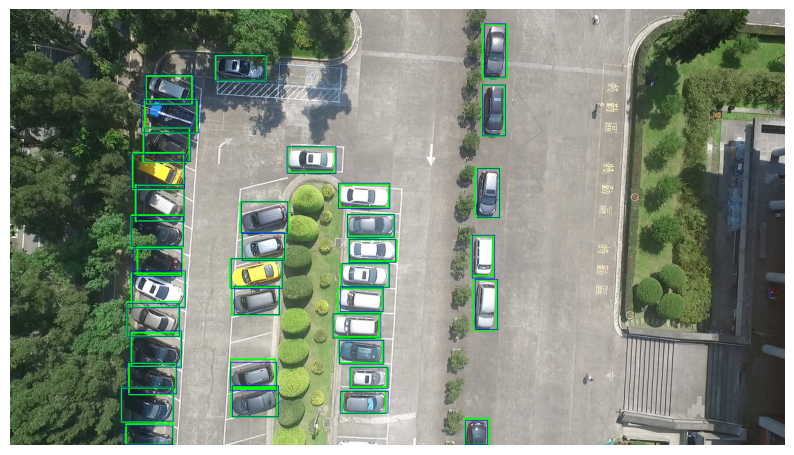

❌ Mismatch Example:


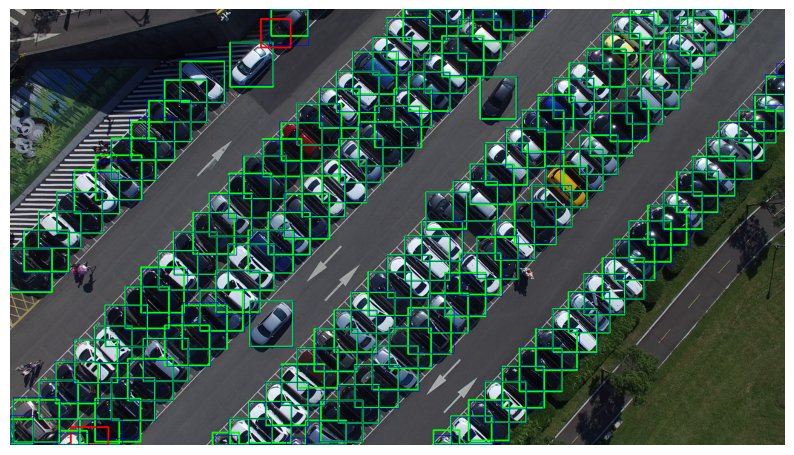

In [ ]:
def load_labels(label_path):
    boxes = []
    if not os.path.exists(label_path):
        return boxes
    with open(label_path, 'r') as f:
        for line in f.readlines():
            cls, x, y, w, h = map(float, line.strip().split())
            boxes.append([cls, x, y, w, h])
    return boxes


def yolo_to_box(box, img_w, img_h):
    _, x, y, w, h = box
    x1 = int((x - w / 2) * img_w)
    y1 = int((y - h / 2) * img_h)
    x2 = int((x + w / 2) * img_w)
    y2 = int((y + h / 2) * img_h)
    return [x1, y1, x2, y2]


def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = max(0, box1[2] - box1[0]) * max(0, box1[3] - box1[1])
    box2_area = max(0, box2[2] - box2[0]) * max(0, box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area
    if union_area == 0:
        return 0
    return inter_area / union_area


def show_image_with_boxes(img_path, gt_boxes, pred_boxes):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    gt_pixels = [yolo_to_box(b, w, h) for b in gt_boxes]
    pred_pixels = [yolo_to_box(b, w, h) for b in pred_boxes]

    for box in pred_pixels:
        matched = any(iou(box, gt) > 0.5 for gt in gt_pixels)
        color = (0, 255, 0) if matched else (255, 0, 0)
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)

    for box in gt_pixels:
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


model_name = "freeze_0_blocks_br_16_lr_0.001_adam_iou_0.5"
pred_folder = f"yolo_test_predictions/{model_name}/labels"
gt_image_folder = "yolo_cars_dataset/test/images"
gt_label_folder = "yolo_cars_dataset/test/labels"


all_files = [f for f in os.listdir(pred_folder) if f.endswith(".txt")]
random.shuffle(all_files)

match_img = None
mismatch_img = None

for label_file in all_files:
    pred_path = os.path.join(pred_folder, label_file)
    gt_path = os.path.join(gt_label_folder, label_file)
    img_name = label_file.replace(".txt", ".png")
    img_path = os.path.join(gt_image_folder, img_name)

    pred_boxes = load_labels(pred_path)
    gt_boxes = load_labels(gt_path)

    if not os.path.exists(img_path) or len(gt_boxes) == 0:
        print(f"Image not found or no GT boxes for {img_path}. Skipping.")
        continue

    if len(pred_boxes) == len(gt_boxes):
        match_img = (img_path, gt_boxes, pred_boxes)
    else:
        mismatch_img = (img_path, gt_boxes, pred_boxes)

    if match_img and mismatch_img:
        break

if match_img:
    print("✅ Exact Match Example:")
    show_image_with_boxes(*match_img)
else:
    print("⚠️ No exact match example found.")

if mismatch_img:
    print("❌ Mismatch Example:")
    show_image_with_boxes(*mismatch_img)
else:
    print("⚠️ No mismatch example found.")

## Alternative Methods for the Object Counting Problem

Alternative techniques can be used in object counting aside from object detection models such as YOLO. There is a couple of other methods available to handle the problem of object counting. They differ in terms of complexity and the suitability based upon object density, occlusion, and perspective distortion.

Density Map Estimation (Crowd Counting Networks)

Instead of detecting objects individually, density-based methods estimate a continuous density map such that the integration over an area equates to the number of objects. Effective models include CSRNet, MCNN, or Bayesian Loss Networks and are suited to dense scenes with high occlusion rates such as parking lots or crowds.

Regression-Based Approaches

These models directly regress the number of objects from the image using convolutional neural networks (CNNs). They do not need localization since they learn to map the whole image to a scalar count. Though they are simple, they tend to degrade in the case of varying object size or layout in the scene.

Segmentation-Based Approaches

Instance segmentation models such as Mask R-CNN can detect and outline each object separately and thereby enable accurate counts and pixel-level localization. These are particularly beneficial when boundaries between objects are significant or when a large overlap exists.

Conventional Computer Vision Approaches

Prior to the advent of deep learning, the common methods employed in the past included blob detection, contour analysis, or background subtraction. Such methods are lightweight and are still applicable in constrained environments where the cameras and object separation are fixed.

Hybrid Approaches

Recent work also merges object detection and density estimation or applies multi-task learning to boost robustness. They may use models to detect coarse object locations and then estimate counts using a density head, e.g. There are trade-offs among each method in terms of annotation needs, interpretability, and performance across varying conditions. Method selection is based on the character of the dataset and the need for precision and swiftness in the application.
